In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import trange 
import sys 
sys.path.insert(0, '../src/')

import pandas as pd 
import numpy as np 
from datetime import datetime 
import torch 
from torchsummary import summary 

import plotly.graph_objects as go 
import plotly.express as px 


import proption_model 
import hierachy_encoding 
import utils 
import preprocessing 

from pyro.distributions import Dirichlet
from pyro.contrib.forecast import eval_crps  

In [2]:
sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('../data/sales_train_evaluation.csv') 
calender = pd.read_csv('../data/calendar.csv') 
date_to_d = dict(zip(calender.date, calender.d)) 
d_to_date = dict(zip(calender.d, calender.date)) 

- Sales Train Evaluation 

In [3]:
## ad-hoc data analysis 
df = sales_train_evaluation.groupby('cat_id').sum()
df = df.T.reset_index()
df 
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='food',
        mode="lines", 
        x=df["index"], 
        y=df["FOODS"],
    )
)

fig.add_trace(
    go.Scatter(
        name='hobbies',
        mode="lines", 
        x=df["index"], 
        y=df["HOBBIES"],
    )
)

fig.add_trace(
    go.Scatter(
        name='household',
        mode="lines", 
        x=df["index"], 
        y=df["HOUSEHOLD"],
    )
)


In [4]:
#sales_train_evaluation.rename(columns=d_to_date, inplace=True)
COLUMNS = sales_train_evaluation.columns.to_list()
dirty_data = sales_train_evaluation[COLUMNS[:6] + ['d_331','d_697','d_1062','d_1427','d_1792']]
dirty_data 


id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_331  d_697  d_1062  d_1427  d_1792  
0         CA_1       CA      0      0       0       0       0  
1         CA_1       CA      0      0       0       0       0  
2         CA_1       CA      0      0       0       0       0  
3         CA_1       CA      0      0       0       0       0  
4         CA_1       CA      0      0       0       0       0  
...        ...      ...    ...    ...     ...     ...     ...  
30485     WI_3       WI      0      0       0       0       0  
30486     WI_3       WI      0      0       0       0       0  
30487     WI_3       WI      0      0       0       0       0  
30488     WI_3       WI      0      0       0       0       0  
30489     WI_3       WI      0      0       0       0       0  

[30490 rows x 11 columns]

In [5]:
dirty_data.groupby('dept_id').sum()

d_331  d_697  d_1062  d_1427  d_1792
dept_id                                          
FOODS_1          0      1       0       2       1
FOODS_2          0      0       0       1       0
FOODS_3         13     10      20      17      12
HOBBIES_1        0      0       0       0       0
HOBBIES_2        0      0       0       0       0
HOUSEHOLD_1      0      0       0       0       0
HOUSEHOLD_2      0      0       0       0       1

- Data Correction 

In [6]:
# past one unit filling 
sales_train_evaluation['d_331'] = sales_train_evaluation['d_330']
sales_train_evaluation['d_697'] = sales_train_evaluation['d_696']
sales_train_evaluation['d_1062'] = sales_train_evaluation['d_1061']
sales_train_evaluation['d_1427'] = sales_train_evaluation['d_1426']
sales_train_evaluation['d_1792'] = sales_train_evaluation['d_1791']

In [7]:
## ad-hoc data analysis 
df_c = sales_train_evaluation.groupby('cat_id').sum()
df_c = df_c.T.reset_index()
df_c

cat_id   index  FOODS  HOBBIES  HOUSEHOLD
0          d_1  23178     3764       5689
1          d_2  22758     3357       5634
2          d_3  17174     2682       3927
3          d_4  18878     2669       3865
4          d_5  14603     1814       2729
...        ...    ...      ...        ...
1936    d_1937  24790     3740       8566
1937    d_1938  24737     3475       8751
1938    d_1939  28136     4143      10273
1939    d_1940  33599     5333      12586
1940    d_1941  35967     5280      13091

[1941 rows x 4 columns]

In [8]:
df_c[df_c.values == 0]

Empty DataFrame
Columns: [index, FOODS, HOBBIES, HOUSEHOLD]
Index: []

In [9]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='food',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["FOODS"],
    )
)

fig.add_trace(
    go.Scatter(
        name='hobbies',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["HOBBIES"],
    )
)

fig.add_trace(
    go.Scatter(
        name='household',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["HOUSEHOLD"],
    )
)

- Sales Train Validation 

In [10]:
## ad-hoc data analysis 
df = sales_train_validation.groupby('cat_id').sum()
df = df.T.reset_index()
df 
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='food',
        mode="lines", 
        x=df["index"], 
        y=df["FOODS"],
    )
)

fig.add_trace(
    go.Scatter(
        name='hobbies',
        mode="lines", 
        x=df["index"], 
        y=df["HOBBIES"],
    )
)

fig.add_trace(
    go.Scatter(
        name='household',
        mode="lines", 
        x=df["index"], 
        y=df["HOUSEHOLD"],
    )
)

In [11]:
# past one unit filling 
sales_train_validation['d_331'] = sales_train_validation['d_330']
sales_train_validation['d_697'] = sales_train_validation['d_696']
sales_train_validation['d_1062'] = sales_train_validation['d_1061']
sales_train_validation['d_1427'] = sales_train_validation['d_1426']
sales_train_validation['d_1792'] = sales_train_validation['d_1791'] 

In [12]:
## ad-hoc data analysis 
df_c = sales_train_validation.groupby('cat_id').sum()
df_c = df_c.T.reset_index()
df_c 

cat_id   index  FOODS  HOBBIES  HOUSEHOLD
0          d_1  23178     3764       5689
1          d_2  22758     3357       5634
2          d_3  17174     2682       3927
3          d_4  18878     2669       3865
4          d_5  14603     1814       2729
...        ...    ...      ...        ...
1908    d_1909  23632     3472       8239
1909    d_1910  23317     3353       8363
1910    d_1911  26704     4085       9728
1911    d_1912  31927     4787      12248
1912    d_1913  32654     4683      12458

[1913 rows x 4 columns]

In [13]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='food',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["FOODS"],
    )
)

fig.add_trace(
    go.Scatter(
        name='hobbies',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["HOBBIES"],
    )
)

fig.add_trace(
    go.Scatter(
        name='household',
        mode="lines", 
        x=df_c["index"], 
        y=df_c["HOUSEHOLD"],
    )
)

## Parent nodes sales 

In [14]:
parent_sales = sales_train_evaluation[sales_train_evaluation.columns[6:]].sum(axis=0).values
print(parent_sales.shape) 

(1941,)


In [15]:
(parent_sales == 0).sum()

0

## Hie EDA 

In [16]:
sales_train_evaluation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [17]:
print(sales_train_evaluation.shape)
print(sales_train_evaluation.columns[:6])

(30490, 1947)
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')


In [18]:
groupby_list = ['state_id','store_id','cat_id','dept_id','item_id']

- Fully encoded hierachy 

In [19]:
hierachy_lookup = sales_train_evaluation.groupby(groupby_list[:]).count()[['id']]
hierachy_lookup

id
state_id store_id cat_id    dept_id     item_id            
CA       CA_1     FOODS     FOODS_1     FOODS_1_001       1
                                        FOODS_1_002       1
                                        FOODS_1_003       1
                                        FOODS_1_004       1
                                        FOODS_1_005       1
...                                                      ..
WI       WI_3     HOUSEHOLD HOUSEHOLD_2 HOUSEHOLD_2_512   1
                                        HOUSEHOLD_2_513   1
                                        HOUSEHOLD_2_514   1
                                        HOUSEHOLD_2_515   1
                                        HOUSEHOLD_2_516   1

[30490 rows x 1 columns]

In [20]:
#hierachy_lookup.loc[('CA','CA_1','FOODS','FOODS_1')].index.to_list()

- Partially encoded hierachy

In [21]:
hierachy_lookup_2 = sales_train_evaluation.groupby(groupby_list[2:]).count()[['id']]
hierachy_lookup_2.head()

id
cat_id dept_id item_id        
FOODS  FOODS_1 FOODS_1_001  10
               FOODS_1_002  10
               FOODS_1_003  10
               FOODS_1_004  10
               FOODS_1_005  10

In [22]:
hierachy_lookup_2

id
cat_id    dept_id     item_id            
FOODS     FOODS_1     FOODS_1_001      10
                      FOODS_1_002      10
                      FOODS_1_003      10
                      FOODS_1_004      10
                      FOODS_1_005      10
...                                    ..
HOUSEHOLD HOUSEHOLD_2 HOUSEHOLD_2_512  10
                      HOUSEHOLD_2_513  10
                      HOUSEHOLD_2_514  10
                      HOUSEHOLD_2_515  10
                      HOUSEHOLD_2_516  10

[3049 rows x 1 columns]

- Category encoded hierachy 

In [23]:
sales_train_evaluation.groupby(groupby_list[2]).count()[['id']]

id
cat_id          
FOODS      14370
HOBBIES     5650
HOUSEHOLD  10470

- TS encoding generation

In [24]:
hierachy_lookup_2 = hierachy_lookup_2.reset_index()

In [25]:
hierachy_lookup_2.dept_id.value_counts()

FOODS_3        823
HOUSEHOLD_1    532
HOUSEHOLD_2    515
HOBBIES_1      416
FOODS_2        398
FOODS_1        216
HOBBIES_2      149
Name: dept_id, dtype: int64

In [26]:

hierachy_with_encoded_columns = hierachy_encoding.hie_encoder(hierachy_lookup_2, ['cat_id','dept_id','item_id'])

root_to_index = {'root':0}

cat_to_dix = dict(zip(hierachy_with_encoded_columns.cat_id,hierachy_with_encoded_columns.cat_id_))
print(cat_to_dix)


dep_to_dix = dict(zip(hierachy_with_encoded_columns.dept_id,hierachy_with_encoded_columns.dept_id_))
print(dep_to_dix)

item_to_dix = dict(zip(hierachy_with_encoded_columns.item_id,hierachy_with_encoded_columns.item_id_))
#print(item_to_dix)

{'FOODS': 0, 'HOBBIES': 1, 'HOUSEHOLD': 2}
{'FOODS_1': 3, 'FOODS_2': 4, 'FOODS_3': 5, 'HOBBIES_1': 6, 'HOBBIES_2': 7, 'HOUSEHOLD_1': 8, 'HOUSEHOLD_2': 9}


In [27]:
ts_to_index = {}
for dic in [root_to_index, cat_to_dix, dep_to_dix, item_to_dix]:
    ts_to_index.update(dic)
print(len(ts_to_index.items()))

3060


In [28]:
inde_to_ts = dict(zip(ts_to_index.values(), ts_to_index.keys()))
print(len(inde_to_ts.items()))

3059


In [29]:
dep_parent_index = hierachy_encoding.get_parent_index(dep_to_dix, cat_to_dix)
dep_parent_index 

defaultdict(int,
            {'FOODS_1': 0,
             'FOODS_2': 0,
             'FOODS_3': 0,
             'HOBBIES_1': 1,
             'HOBBIES_2': 1,
             'HOUSEHOLD_1': 2,
             'HOUSEHOLD_2': 2})

In [30]:
item_parent_index = hierachy_encoding.get_parent_index(item_to_dix, dep_to_dix)

---- Need to constrcut a grpah here, proceeed to next step first 

In [31]:
hierachy_encoding.get_children_index(cat_to_dix)

defaultdict(list, {'root': [0, 1, 2]})

- Pick a particular familry to construct one training data points 
    - Parent node - 0 
    - Children node - 1, 2, 3 

In [32]:
# collect parent sales 
yp = sales_train_validation.sum(axis=0)[6:].values.reshape(-1,1)# np array 
yp = yp.T 
print(yp.shape)

(1, 1913)


In [33]:
yp

array([[32631, 31749, 23783, ..., 40517, 48962, 49795]], dtype=object)

In [34]:
sum_of_sales = sales_train_validation.groupby('cat_id').sum()
sum_of_sales = sum_of_sales.rename(columns=d_to_date)
sum_of_sales 

2011-01-29  2011-01-30  2011-01-31  2011-02-01  2011-02-02  \
cat_id                                                                  
FOODS           23178       22758       17174       18878       14603   
HOBBIES          3764        3357        2682        2669        1814   
HOUSEHOLD        5689        5634        3927        3865        2729   

           2011-02-03  2011-02-04  2011-02-05  2011-02-06  2011-02-07  ...  \
cat_id                                                                 ...   
FOODS           22093       20490       27751       24862       18901  ...   
HOBBIES          3220        2944        3986        2899        2615  ...   
HOUSEHOLD        3898        4576        6195        4975        4056  ...   

           2016-04-15  2016-04-16  2016-04-17  2016-04-18  2016-04-19  \
cat_id                                                                  
FOODS           28682       32007       34497       26151       24948   
HOBBIES          3786        4634        4820        3323        3787   
HOUSEHOLD        9321       11721       12323        8585        8835   

           2016-04-20  2016-04-21  2016-04-22  2016-04-23  2016-04-24  
cat_id                                                                 
FOODS           23632       23317       26704       31927       32654  
HOBBIES          3472        3353        4085        4787        4683  
HOUSEHOLD        8239        8363        9728       12248       12458  

[3 rows x 1913 columns]

In [35]:
sum_of_sales_transposed = sum_of_sales.T.reset_index().rename(columns = {"index":"dates"})
sum_of_sales_transposed

cat_id       dates  FOODS  HOBBIES  HOUSEHOLD
0       2011-01-29  23178     3764       5689
1       2011-01-30  22758     3357       5634
2       2011-01-31  17174     2682       3927
3       2011-02-01  18878     2669       3865
4       2011-02-02  14603     1814       2729
...            ...    ...      ...        ...
1908    2016-04-20  23632     3472       8239
1909    2016-04-21  23317     3353       8363
1910    2016-04-22  26704     4085       9728
1911    2016-04-23  31927     4787      12248
1912    2016-04-24  32654     4683      12458

[1913 rows x 4 columns]

In [36]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='food',
        mode="lines", 
        x=sum_of_sales_transposed["dates"], 
        y=sum_of_sales_transposed["FOODS"],
        )
)


In [37]:
sum_of_sales_transposed[sum_of_sales_transposed.values == 0]

Empty DataFrame
Columns: [dates, FOODS, HOBBIES, HOUSEHOLD]
Index: []

In [38]:
# collect the proportinos 
ac = sales_train_validation.groupby('cat_id').sum().values/yp
print(ac.shape)
print(type(ac)) 

(3, 1913)
<class 'numpy.ndarray'>


In [39]:
print(ac.sum(axis=0).sum())
print(len(ac.sum(axis=0)))

1913.0
1913


In [40]:
ac_df = sales_train_validation.groupby('cat_id').sum()/yp
ac_df = ac_df.rename(columns=d_to_date)
ac_df

2011-01-29 2011-01-30 2011-01-31 2011-02-01 2011-02-02 2011-02-03  \
cat_id                                                                        
FOODS       0.710306    0.71681   0.722112   0.742877   0.762718   0.756325   
HOBBIES      0.11535   0.105736    0.11277   0.105029   0.094746   0.110232   
HOUSEHOLD   0.174343   0.177454   0.165118   0.152093   0.142536   0.133443   

          2011-02-04 2011-02-05 2011-02-06 2011-02-07  ... 2016-04-15  \
cat_id                                                 ...              
FOODS       0.731524   0.731599    0.75947   0.739129  ...   0.686353   
HOBBIES     0.105105   0.105083   0.088557    0.10226  ...   0.090598   
HOUSEHOLD    0.16337   0.163319   0.151973   0.158611  ...   0.223049   

          2016-04-16 2016-04-17 2016-04-18 2016-04-19 2016-04-20 2016-04-21  \
cat_id                                                                        
FOODS       0.661821   0.668029   0.687117    0.66404   0.668647   0.665572   
HOBBIES     0.095819   0.093338   0.087312   0.100799   0.098237    0.09571   
HOUSEHOLD    0.24236   0.238633   0.225571   0.235161   0.233115   0.238718   

          2016-04-22 2016-04-23 2016-04-24  
cat_id                                      
FOODS       0.659081   0.652077   0.655769  
HOBBIES     0.100822    0.09777   0.094046  
HOUSEHOLD   0.240097   0.250153   0.250186  

[3 rows x 1913 columns]

In [41]:
# visualise the distributions 
ac_df_t = ac_df.T
ac_df_t = ac_df_t.reset_index()
ac_df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      1913 non-null   object
 1   FOODS      1913 non-null   object
 2   HOBBIES    1913 non-null   object
 3   HOUSEHOLD  1913 non-null   object
dtypes: object(4)
memory usage: 59.9+ KB


In [42]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
        )
    )

fig.show()

In [43]:
# collect the embedding layer input 
ec = np.array(hierachy_encoding.get_children_index(cat_to_dix)['root']).reshape(-1,1)
ec = np.repeat(ec, 1913, axis=1)
print(ec.shape)
print(type(ec))

(3, 1913)
<class 'numpy.ndarray'>


In [44]:
ec[:,0]

array([0, 1, 2])

In [45]:
if ac.shape[0] == ec.shape[0]: 

    input = np.empty(
        
        (ac.shape[0], ac.shape[1], 3), 
    
    )
    print(input.shape)

    for c in range(input.shape[0]): 
        print(c)
        # print(yp.T.shape)
        # print(ac[c].reshape(-1,1).shape)
        # print(ec[c].reshape(-1,1).shape)
        input[c] = np.concatenate(
            [
                ac[c].reshape(-1,1), 
                yp.T, 
                ## ---- PLACE HOLDER FOR COVARIATES X ---- ## 
                ## ---- PLACE HOLDER FOR COVARIATES X ---- ## 
                ec[c].reshape(-1,1),
            ], 
            axis = 1 
        )
        print(input[c].shape)    
else: 
    raise "size of children in embedding does not agree with size of the children in proportions"

(3, 1913, 3)
0
(1913, 3)
1
(1913, 3)
2
(1913, 3)


In [46]:
print(input.shape)

(3, 1913, 3)


In [47]:
## time batching 
# dimension about the dataset
print('------- Time batched input --------')
History = 28 
Forward = 7

number_observations = input.shape[1] - (History + Forward) + 1

input_time_batched = np.empty(
    (number_observations,input.shape[0], History + Forward, input.shape[-1])
)

for i in range(number_observations):

    input_time_batched[i] = np.array(input[:, i:i + History + Forward, :])

print(input_time_batched.shape)
# print(input_time_batched[0][0])

print("-------- X, y split ------------")
input_array = np.empty((
    number_observations,
    input.shape[0],
    History,
    input.shape[-1])
)

target_array = np.empty((
    number_observations,
    input.shape[0],
    Forward,
    1)
)

# print(input_tensor.shape)
# print(target_tensor.shape)

for i in range(input_time_batched.shape[0]):

    input_array[i] = input_time_batched[i, :, :History, :]

    #print(input_array[i,0,-1,0])

    target_2d = input_time_batched[i, :, History:, 0]
    
    target_array[i] = target_2d.reshape(
        target_2d.shape[0], target_2d.shape[1], 1
    )

    #print(target_array[i,0,0,0])
    #print()

print(f"X input shape is {input_array.shape}")
print(f"y input shape is {target_array.shape}")


------- Time batched input --------
(1879, 3, 35, 3)
-------- X, y split ------------
X input shape is (1879, 3, 28, 3)
y input shape is (1879, 3, 7, 1)


- batched input checking

In [86]:
for i in range(input_array.shape[0]):
    sum = (input_array[i,:,:,0] == ac[:,i:28+i]).sum()
    assert sum/3 == 28
    

In [87]:
for i in range(target_array.shape[0]):
    sum = (target_array[0,:,:,0] == ac[:,28:28+7]).sum()
    assert sum/3 == 7 

In [88]:
for i in range(target_array.shape[0]):
    (target_array[i,:,:,0] == ac[:,i:28+7+i])

/var/folders/6t/cwpxfjt13rd3m9sgky7446mm0000gn/T/ipykernel_39001/1913190142.py:2: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



- blue box X shape (1893, 2, 14, 3)
- green box X shape (1893, 2, 14, 3)
- y target is the proportal of ever single child 


In [90]:
train_input_array, train_target_array = preprocessing.pre_processing_main(
    sales_train_validation, 
    cat_to_dix,
    History,
    Forward,
)

(3, 1913, 3)
0
(1913, 3)
1
(1913, 3)
2
(1913, 3)
-------- X, y split ------------
X input shape is (1879, 3, 28, 3)
y input shape is (1879, 3, 7, 1)


## Vlidation set  

In [91]:
val_input_array, val_target_array = preprocessing.pre_processing_main(
    sales_train_evaluation, 
    cat_to_dix,
    History,
    Forward,
)

(3, 1941, 3)
0
(1941, 3)
1
(1941, 3)
2
(1941, 3)
-------- X, y split ------------
X input shape is (1907, 3, 28, 3)
y input shape is (1907, 3, 7, 1)


In [92]:
#val_input_array[0]

## Training 

### 1. Define the model object 

In [112]:
### convert np array into torch array 
input_tensor = torch.tensor(train_input_array).float()
target_tensor = torch.tensor(train_target_array).float()

val_input_tensor = torch.tensor(val_input_array).float()[-1]
val_targer_tensor = torch.tensor(val_target_array).float()[-1]

print('The shape of the training tensors is')
print(input_tensor.shape)
print(target_tensor.shape)

print('The shape of the entire validation tensors is')
print(val_input_tensor.shape)
print(val_targer_tensor.shape)

###---------- dimension on the model hypter-parameters from the paper ------------ ######
no_child = 3060 
num_hts_embedd = no_child
hts_embedd_dim = 8
covariate_dim = 0

lstm_input_dim = 2 + covariate_dim + hts_embedd_dim
lstm_hidden_dim = 48
"""
Increase the number of LSTM layer TO 4
"""
lstm_num_layer = 1 
lstm_output_dim = 64

mha_embedd_dim = lstm_output_dim
num_head = 4
num_attention_layer = 1
mha_output_dim = mha_embedd_dim
residual_output_dim = mha_output_dim
model_ouput_dim = 1

# define the model object
model= proption_model.ProportionModel(
    Forward,
    num_hts_embedd,
    hts_embedd_dim,  # ts embedding hyper pars
    lstm_input_dim,
    lstm_hidden_dim,
    lstm_num_layer,
    lstm_output_dim,  # lstm hyper pars
    mha_embedd_dim,
    num_head,
    num_attention_layer,  # mha hyper pars
    mha_output_dim,
    residual_output_dim,  # skip connection hyper pars
    model_ouput_dim,  # output later hyper pars
    mha_activation = torch.nn.ReLU()
)


The shape of the training tensors is
torch.Size([1879, 3, 28, 3])
torch.Size([1879, 3, 7, 1])
The shape of the entire validation tensors is
torch.Size([3, 28, 3])
torch.Size([3, 7, 1])


### Adam Opts

Trainign starting from iteration 0, batch 0
There are 470 batches per iteration


  0%|          | 0/10 [00:00<?, ?it/s]

Trainign for Iteration: 0 starts
Training for Iteration: 0 Batch 0 starts
Loss exploded to 14.613836288452148 at 1
Training for Iteration: 0 Batch 1 starts
Loss exploded to 13.453879594802856 at 2
Training for Iteration: 0 Batch 2 starts
Loss exploded to 9.18937361240387 at 3
Training for Iteration: 0 Batch 3 starts
Loss exploded to 10.240770697593689 at 4
Training for Iteration: 0 Batch 4 starts
Loss exploded to 10.52998948097229 at 5
Training for Iteration: 0 Batch 5 starts
Loss exploded to 10.175464391708374 at 6
Training for Iteration: 0 Batch 6 starts
Loss exploded to 9.550874590873718 at 7
Training for Iteration: 0 Batch 7 starts
Loss exploded to 9.444689989089966 at 8
Training for Iteration: 0 Batch 8 starts
Loss exploded to 9.944405913352966 at 9
Training for Iteration: 0 Batch 9 starts
Loss exploded to 6.083170175552368 at 10
Training for Iteration: 0 Batch 10 starts
Loss exploded to 8.629160761833191 at 11
Training for Iteration: 0 Batch 11 starts
Loss exploded to 7.597169399

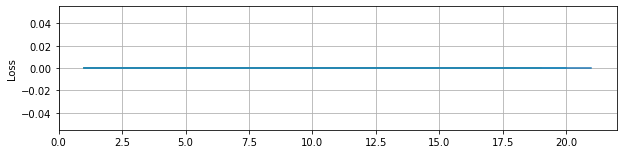

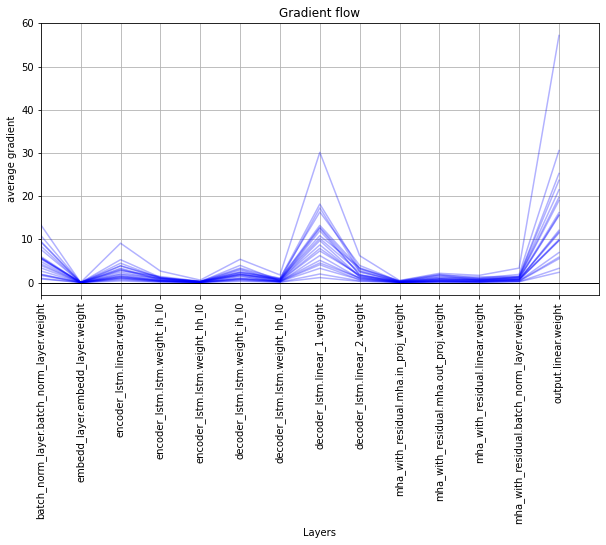

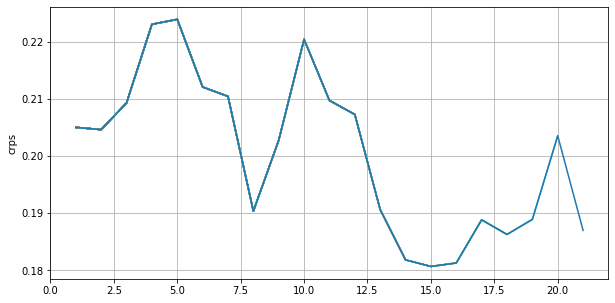

Training for Iteration: 0 Batch 21 starts
Loss exploded to 6.057421624660492 at 22
Training for Iteration: 0 Batch 22 starts
Loss exploded to 4.113296747207642 at 23
Training for Iteration: 0 Batch 23 starts
Loss exploded to 4.317406594753265 at 24
Training for Iteration: 0 Batch 24 starts
Loss exploded to 9.183278679847717 at 25
Training for Iteration: 0 Batch 25 starts
Loss exploded to 7.1963982582092285 at 26
Training for Iteration: 0 Batch 26 starts
Loss exploded to 7.567225873470306 at 27
Training for Iteration: 0 Batch 27 starts
Loss exploded to 4.203216314315796 at 28
Training for Iteration: 0 Batch 28 starts
Loss exploded to 3.8109949231147766 at 29
Training for Iteration: 0 Batch 29 starts
Loss exploded to 1.4219565987586975 at 30
Training for Iteration: 0 Batch 30 starts
Loss exploded to 2.615709513425827 at 31
Training for Iteration: 0 Batch 31 starts
Loss exploded to 3.0997418463230133 at 32
Training for Iteration: 0 Batch 32 starts
Loss exploded to 0.8398459106683731 at 33

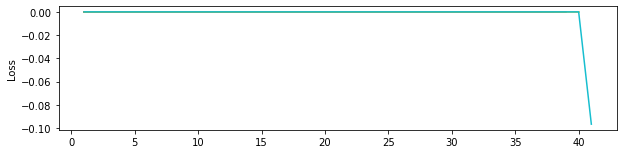

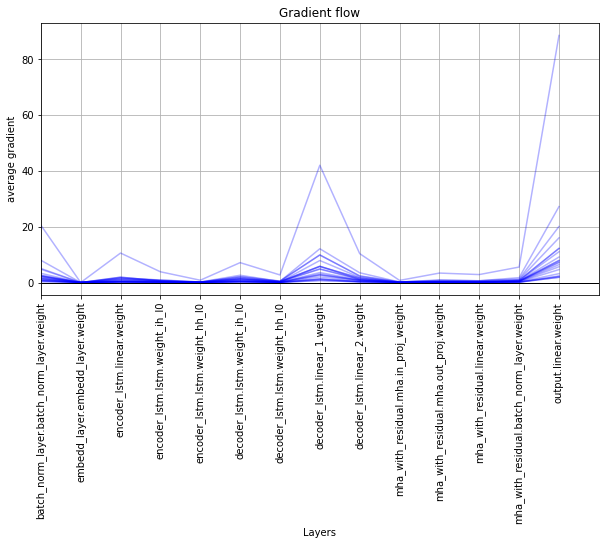

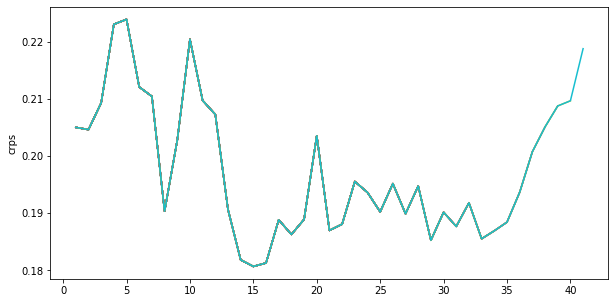

Training for Iteration: 0 Batch 41 starts
Loss exploded to 0.7119156122207642 at 42
Training for Iteration: 0 Batch 42 starts
Training for Iteration: 0 Batch 43 starts
Loss exploded to 0.3510299324989319 at 44
Training for Iteration: 0 Batch 44 starts
Training for Iteration: 0 Batch 45 starts
Training for Iteration: 0 Batch 46 starts
Training for Iteration: 0 Batch 47 starts
Training for Iteration: 0 Batch 48 starts
Training for Iteration: 0 Batch 49 starts
Training for Iteration: 0 Batch 50 starts
Training for Iteration: 0 Batch 51 starts
Training for Iteration: 0 Batch 52 starts
Training for Iteration: 0 Batch 53 starts
Training for Iteration: 0 Batch 54 starts
Training for Iteration: 0 Batch 55 starts
Training for Iteration: 0 Batch 56 starts
Training for Iteration: 0 Batch 57 starts
Training for Iteration: 0 Batch 58 starts
Training for Iteration: 0 Batch 59 starts
Training for Iteration: 0 Batch 60 starts


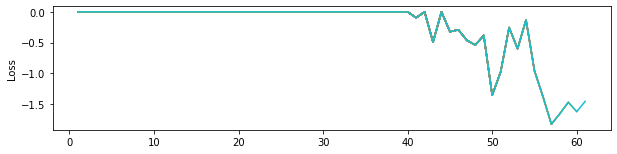

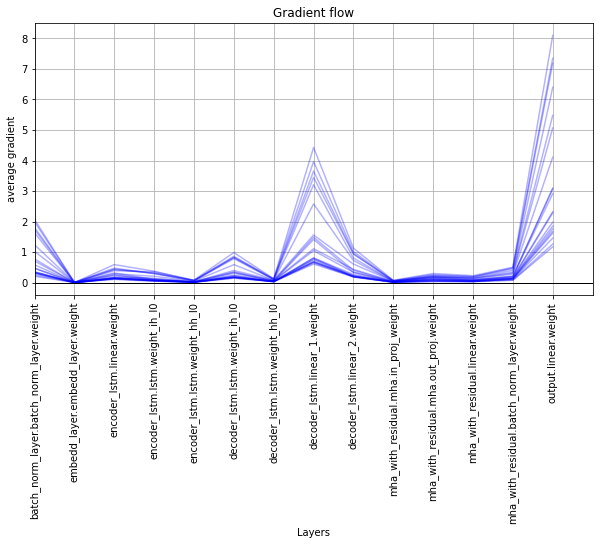

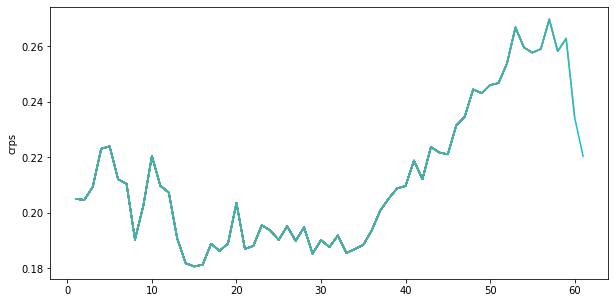

Training for Iteration: 0 Batch 61 starts
Training for Iteration: 0 Batch 62 starts
Training for Iteration: 0 Batch 63 starts
Training for Iteration: 0 Batch 64 starts
Training for Iteration: 0 Batch 65 starts
Training for Iteration: 0 Batch 66 starts
Training for Iteration: 0 Batch 67 starts
Training for Iteration: 0 Batch 68 starts
Training for Iteration: 0 Batch 69 starts
Training for Iteration: 0 Batch 70 starts
Training for Iteration: 0 Batch 71 starts
Training for Iteration: 0 Batch 72 starts
Training for Iteration: 0 Batch 73 starts
Training for Iteration: 0 Batch 74 starts
Training for Iteration: 0 Batch 75 starts
Training for Iteration: 0 Batch 76 starts
Training for Iteration: 0 Batch 77 starts
Training for Iteration: 0 Batch 78 starts
Training for Iteration: 0 Batch 79 starts
Training for Iteration: 0 Batch 80 starts


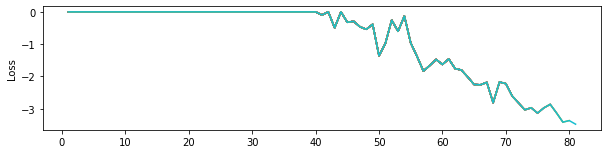

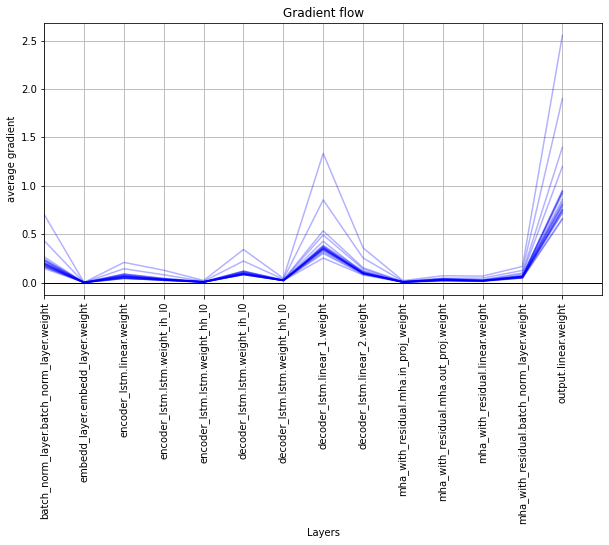

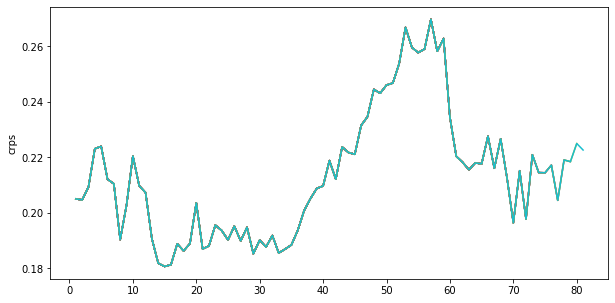

Training for Iteration: 0 Batch 81 starts
Training for Iteration: 0 Batch 82 starts
Training for Iteration: 0 Batch 83 starts
Training for Iteration: 0 Batch 84 starts
Training for Iteration: 0 Batch 85 starts
Training for Iteration: 0 Batch 86 starts
Training for Iteration: 0 Batch 87 starts
Training for Iteration: 0 Batch 88 starts
Training for Iteration: 0 Batch 89 starts
Training for Iteration: 0 Batch 90 starts
Training for Iteration: 0 Batch 91 starts
Training for Iteration: 0 Batch 92 starts
Training for Iteration: 0 Batch 93 starts
Training for Iteration: 0 Batch 94 starts
Training for Iteration: 0 Batch 95 starts
Training for Iteration: 0 Batch 96 starts
Training for Iteration: 0 Batch 97 starts
Training for Iteration: 0 Batch 98 starts
Training for Iteration: 0 Batch 99 starts
Training for Iteration: 0 Batch 100 starts


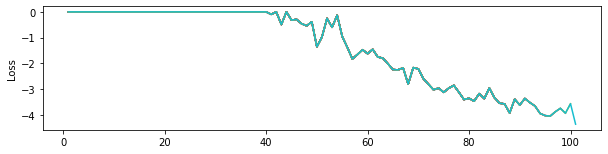

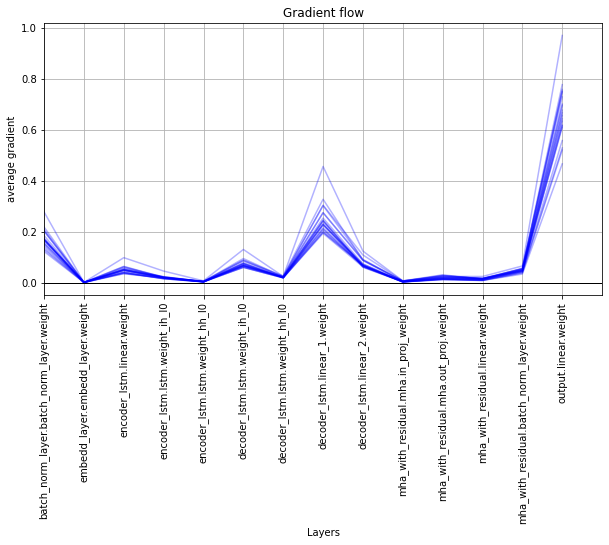

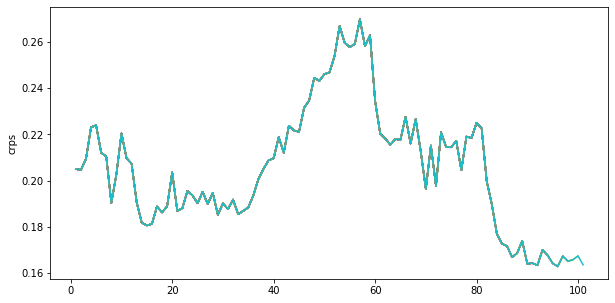

Training for Iteration: 0 Batch 101 starts
Training for Iteration: 0 Batch 102 starts
Training for Iteration: 0 Batch 103 starts
Training for Iteration: 0 Batch 104 starts
Training for Iteration: 0 Batch 105 starts
Training for Iteration: 0 Batch 106 starts
Training for Iteration: 0 Batch 107 starts
Training for Iteration: 0 Batch 108 starts
Training for Iteration: 0 Batch 109 starts
Training for Iteration: 0 Batch 110 starts
Training for Iteration: 0 Batch 111 starts
Training for Iteration: 0 Batch 112 starts
Training for Iteration: 0 Batch 113 starts
Training for Iteration: 0 Batch 114 starts
Training for Iteration: 0 Batch 115 starts
Training for Iteration: 0 Batch 116 starts
Training for Iteration: 0 Batch 117 starts
Training for Iteration: 0 Batch 118 starts
Training for Iteration: 0 Batch 119 starts
Training for Iteration: 0 Batch 120 starts


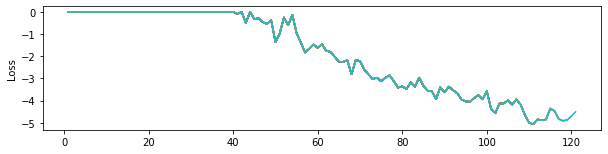

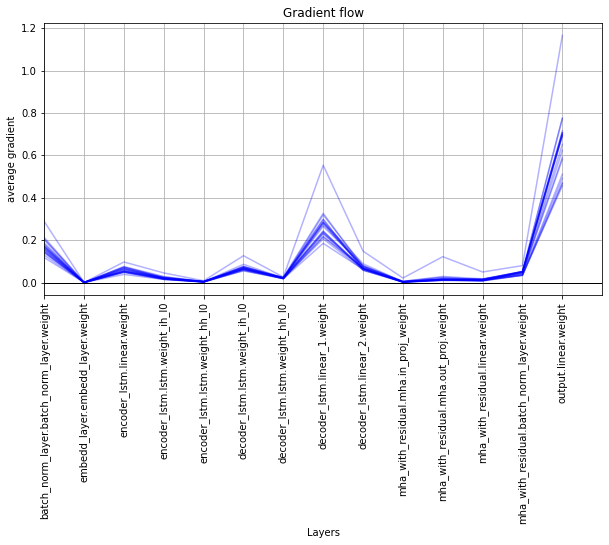

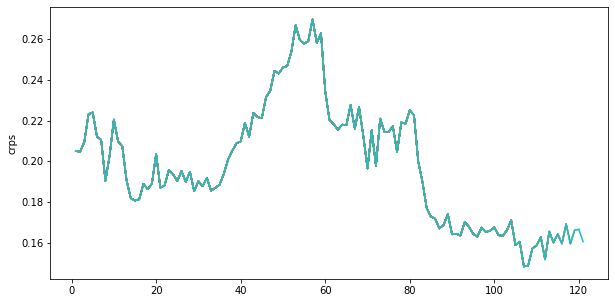

Training for Iteration: 0 Batch 121 starts
Training for Iteration: 0 Batch 122 starts
Training for Iteration: 0 Batch 123 starts
Training for Iteration: 0 Batch 124 starts
Training for Iteration: 0 Batch 125 starts
Training for Iteration: 0 Batch 126 starts
Training for Iteration: 0 Batch 127 starts
Training for Iteration: 0 Batch 128 starts
Training for Iteration: 0 Batch 129 starts
Training for Iteration: 0 Batch 130 starts
Training for Iteration: 0 Batch 131 starts
Training for Iteration: 0 Batch 132 starts
Training for Iteration: 0 Batch 133 starts
Training for Iteration: 0 Batch 134 starts
Training for Iteration: 0 Batch 135 starts
Training for Iteration: 0 Batch 136 starts
Training for Iteration: 0 Batch 137 starts
Training for Iteration: 0 Batch 138 starts
Training for Iteration: 0 Batch 139 starts
Training for Iteration: 0 Batch 140 starts


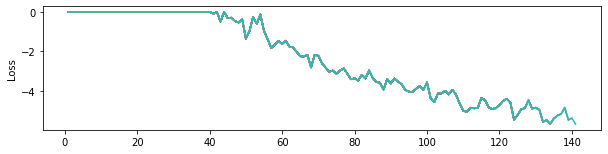

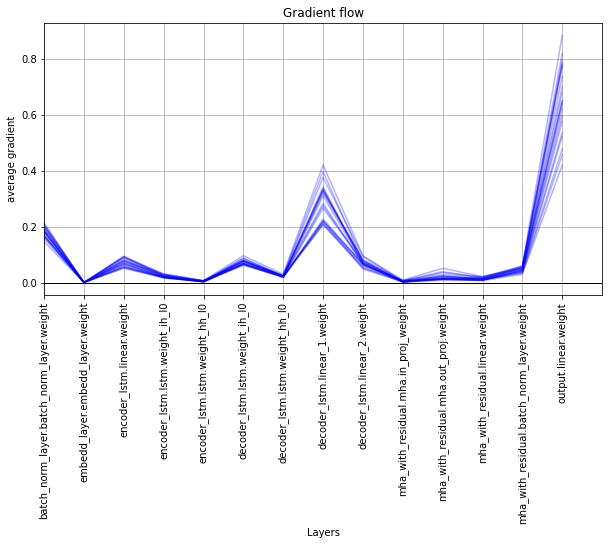

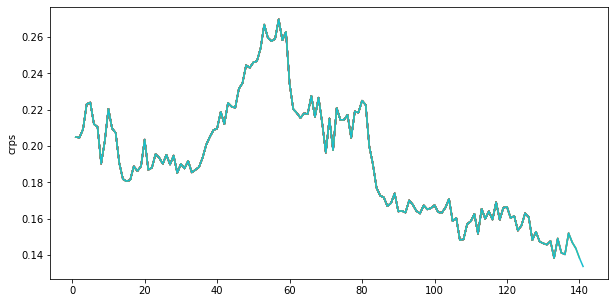

Training for Iteration: 0 Batch 141 starts
Training for Iteration: 0 Batch 142 starts
Training for Iteration: 0 Batch 143 starts
Training for Iteration: 0 Batch 144 starts
Training for Iteration: 0 Batch 145 starts
Training for Iteration: 0 Batch 146 starts
Training for Iteration: 0 Batch 147 starts
Training for Iteration: 0 Batch 148 starts
Training for Iteration: 0 Batch 149 starts
Training for Iteration: 0 Batch 150 starts
Training for Iteration: 0 Batch 151 starts
Training for Iteration: 0 Batch 152 starts
Training for Iteration: 0 Batch 153 starts
Training for Iteration: 0 Batch 154 starts
Training for Iteration: 0 Batch 155 starts
Training for Iteration: 0 Batch 156 starts
Training for Iteration: 0 Batch 157 starts
Training for Iteration: 0 Batch 158 starts
Training for Iteration: 0 Batch 159 starts
Training for Iteration: 0 Batch 160 starts


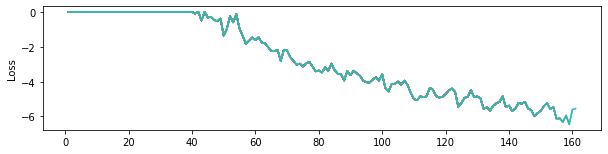

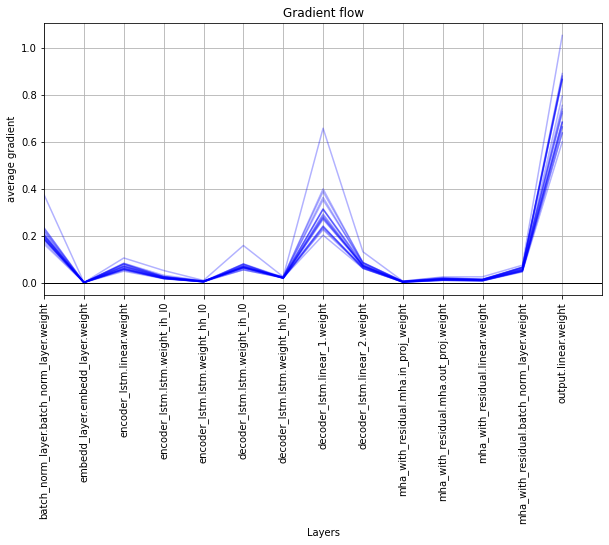

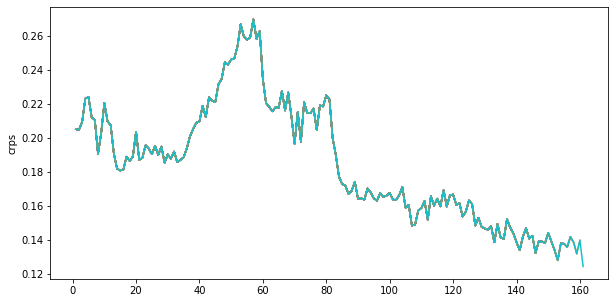

Training for Iteration: 0 Batch 161 starts
Training for Iteration: 0 Batch 162 starts
Training for Iteration: 0 Batch 163 starts
Training for Iteration: 0 Batch 164 starts
Training for Iteration: 0 Batch 165 starts
Training for Iteration: 0 Batch 166 starts
Training for Iteration: 0 Batch 167 starts
Training for Iteration: 0 Batch 168 starts
Training for Iteration: 0 Batch 169 starts
Training for Iteration: 0 Batch 170 starts
Training for Iteration: 0 Batch 171 starts
Training for Iteration: 0 Batch 172 starts
Training for Iteration: 0 Batch 173 starts
Training for Iteration: 0 Batch 174 starts
Training for Iteration: 0 Batch 175 starts
Training for Iteration: 0 Batch 176 starts
Training for Iteration: 0 Batch 177 starts
Training for Iteration: 0 Batch 178 starts
Training for Iteration: 0 Batch 179 starts
Training for Iteration: 0 Batch 180 starts


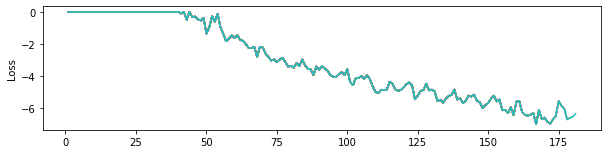

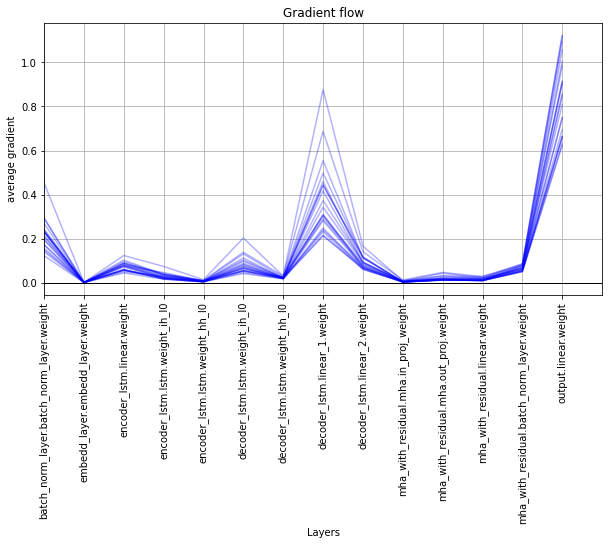

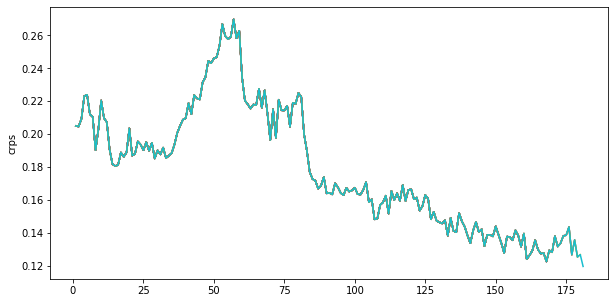

Training for Iteration: 0 Batch 181 starts
Training for Iteration: 0 Batch 182 starts
Training for Iteration: 0 Batch 183 starts
Training for Iteration: 0 Batch 184 starts
Training for Iteration: 0 Batch 185 starts
Training for Iteration: 0 Batch 186 starts
Training for Iteration: 0 Batch 187 starts
Training for Iteration: 0 Batch 188 starts
Training for Iteration: 0 Batch 189 starts
Training for Iteration: 0 Batch 190 starts
Training for Iteration: 0 Batch 191 starts
Training for Iteration: 0 Batch 192 starts
Training for Iteration: 0 Batch 193 starts
Training for Iteration: 0 Batch 194 starts
Training for Iteration: 0 Batch 195 starts
Training for Iteration: 0 Batch 196 starts
Training for Iteration: 0 Batch 197 starts
Training for Iteration: 0 Batch 198 starts
Training for Iteration: 0 Batch 199 starts
Training for Iteration: 0 Batch 200 starts


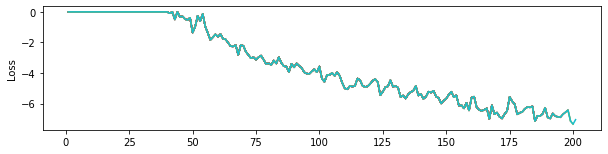

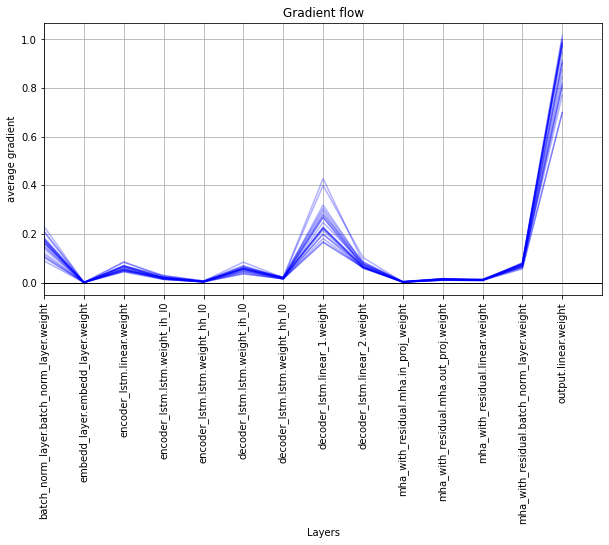

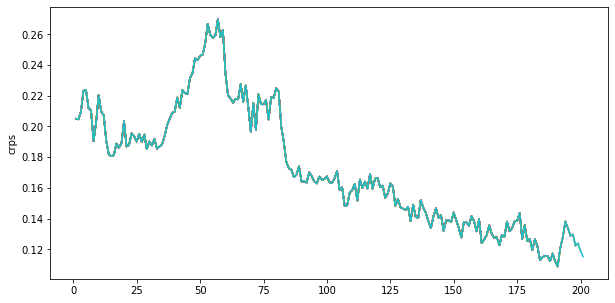

Training for Iteration: 0 Batch 201 starts
Training for Iteration: 0 Batch 202 starts
Training for Iteration: 0 Batch 203 starts
Training for Iteration: 0 Batch 204 starts
Training for Iteration: 0 Batch 205 starts
Training for Iteration: 0 Batch 206 starts
Training for Iteration: 0 Batch 207 starts
Training for Iteration: 0 Batch 208 starts
Training for Iteration: 0 Batch 209 starts
Training for Iteration: 0 Batch 210 starts
Training for Iteration: 0 Batch 211 starts
Training for Iteration: 0 Batch 212 starts
Training for Iteration: 0 Batch 213 starts
Training for Iteration: 0 Batch 214 starts
Training for Iteration: 0 Batch 215 starts
Training for Iteration: 0 Batch 216 starts
Training for Iteration: 0 Batch 217 starts
Training for Iteration: 0 Batch 218 starts
Training for Iteration: 0 Batch 219 starts
Training for Iteration: 0 Batch 220 starts


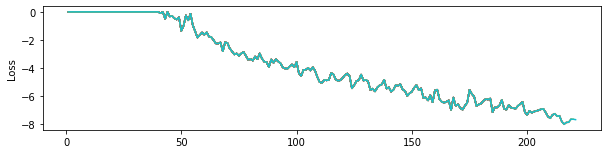

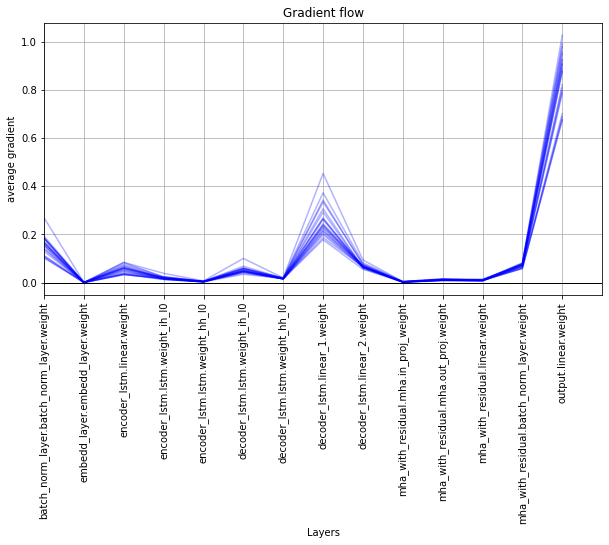

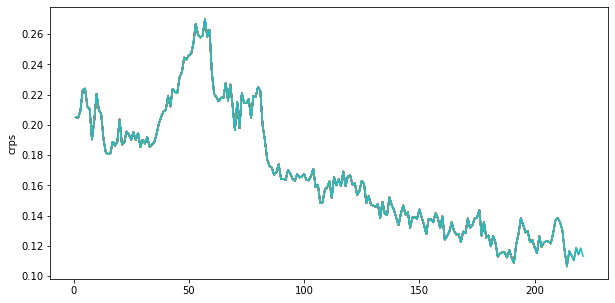

Training for Iteration: 0 Batch 221 starts
Training for Iteration: 0 Batch 222 starts
Training for Iteration: 0 Batch 223 starts
Training for Iteration: 0 Batch 224 starts
Training for Iteration: 0 Batch 225 starts
Training for Iteration: 0 Batch 226 starts
Training for Iteration: 0 Batch 227 starts
Training for Iteration: 0 Batch 228 starts
Training for Iteration: 0 Batch 229 starts
Training for Iteration: 0 Batch 230 starts
Training for Iteration: 0 Batch 231 starts
Training for Iteration: 0 Batch 232 starts
Training for Iteration: 0 Batch 233 starts
Training for Iteration: 0 Batch 234 starts
Training for Iteration: 0 Batch 235 starts
Training for Iteration: 0 Batch 236 starts
Training for Iteration: 0 Batch 237 starts
Training for Iteration: 0 Batch 238 starts
Training for Iteration: 0 Batch 239 starts
Training for Iteration: 0 Batch 240 starts


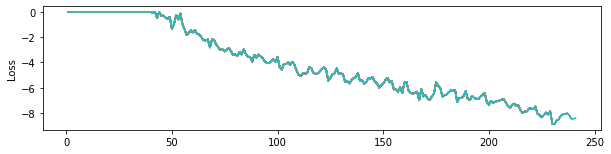

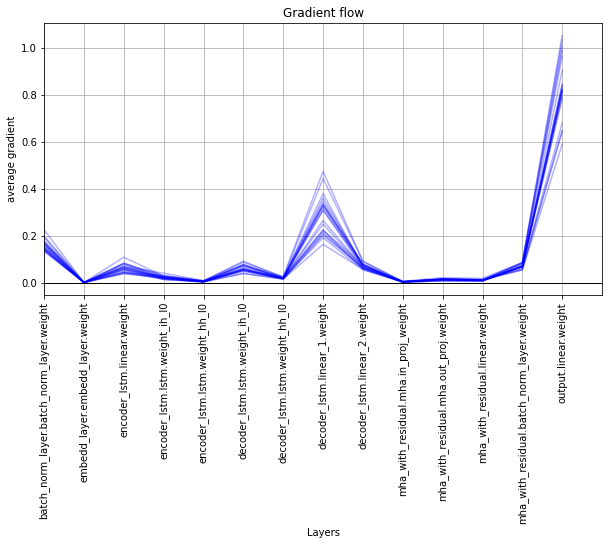

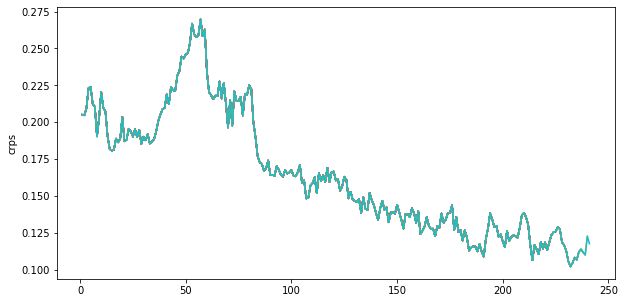

Training for Iteration: 0 Batch 241 starts
Training for Iteration: 0 Batch 242 starts
Training for Iteration: 0 Batch 243 starts
Training for Iteration: 0 Batch 244 starts
Training for Iteration: 0 Batch 245 starts
Training for Iteration: 0 Batch 246 starts
Training for Iteration: 0 Batch 247 starts
Training for Iteration: 0 Batch 248 starts
Training for Iteration: 0 Batch 249 starts
Training for Iteration: 0 Batch 250 starts
Training for Iteration: 0 Batch 251 starts
Training for Iteration: 0 Batch 252 starts
Training for Iteration: 0 Batch 253 starts
Training for Iteration: 0 Batch 254 starts
Training for Iteration: 0 Batch 255 starts
Training for Iteration: 0 Batch 256 starts
Training for Iteration: 0 Batch 257 starts
Training for Iteration: 0 Batch 258 starts
Training for Iteration: 0 Batch 259 starts
Training for Iteration: 0 Batch 260 starts


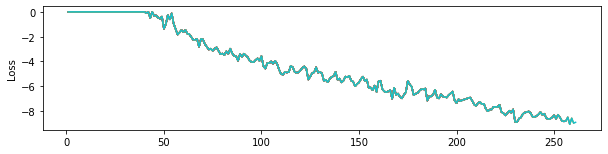

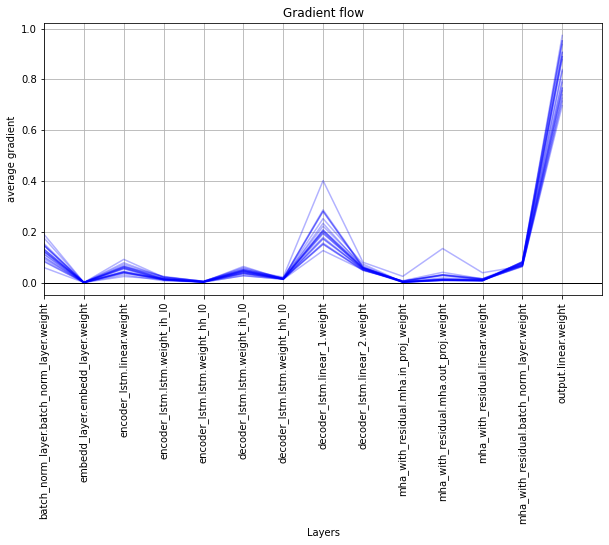

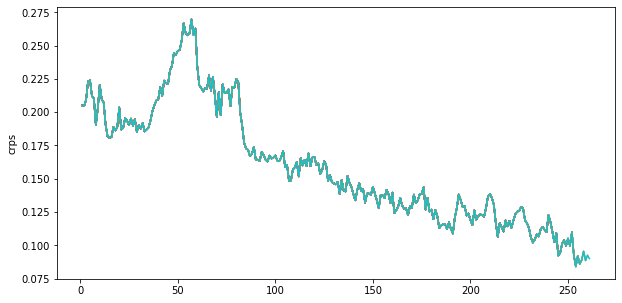

Training for Iteration: 0 Batch 261 starts
Training for Iteration: 0 Batch 262 starts
Training for Iteration: 0 Batch 263 starts
Training for Iteration: 0 Batch 264 starts
Training for Iteration: 0 Batch 265 starts
Training for Iteration: 0 Batch 266 starts
Training for Iteration: 0 Batch 267 starts
Training for Iteration: 0 Batch 268 starts
Training for Iteration: 0 Batch 269 starts
Training for Iteration: 0 Batch 270 starts
Training for Iteration: 0 Batch 271 starts
Training for Iteration: 0 Batch 272 starts
Training for Iteration: 0 Batch 273 starts
Training for Iteration: 0 Batch 274 starts
Training for Iteration: 0 Batch 275 starts
Training for Iteration: 0 Batch 276 starts
Training for Iteration: 0 Batch 277 starts
Training for Iteration: 0 Batch 278 starts
Training for Iteration: 0 Batch 279 starts
Training for Iteration: 0 Batch 280 starts


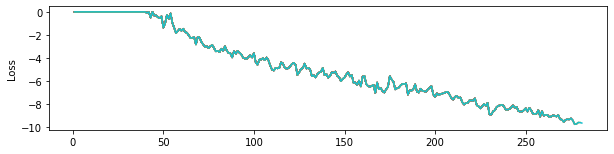

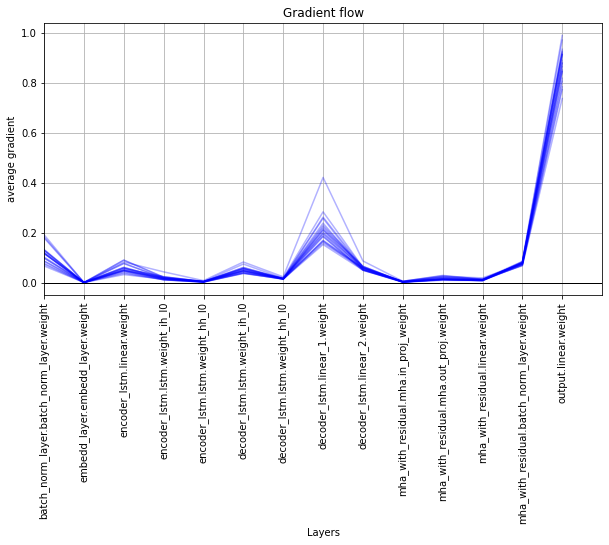

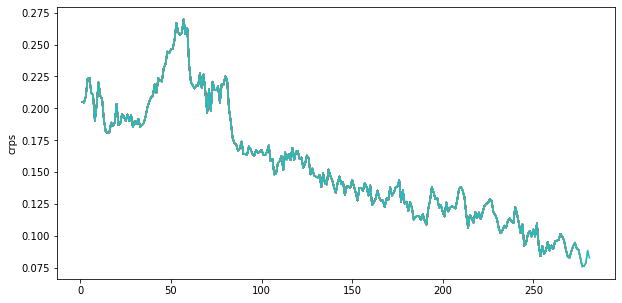

Training for Iteration: 0 Batch 281 starts
Training for Iteration: 0 Batch 282 starts
Training for Iteration: 0 Batch 283 starts
Training for Iteration: 0 Batch 284 starts
Training for Iteration: 0 Batch 285 starts
Training for Iteration: 0 Batch 286 starts
Training for Iteration: 0 Batch 287 starts
Training for Iteration: 0 Batch 288 starts
Training for Iteration: 0 Batch 289 starts
Training for Iteration: 0 Batch 290 starts
Training for Iteration: 0 Batch 291 starts
Training for Iteration: 0 Batch 292 starts
Training for Iteration: 0 Batch 293 starts
Training for Iteration: 0 Batch 294 starts
Training for Iteration: 0 Batch 295 starts
Training for Iteration: 0 Batch 296 starts
Training for Iteration: 0 Batch 297 starts
Training for Iteration: 0 Batch 298 starts
Training for Iteration: 0 Batch 299 starts
Training for Iteration: 0 Batch 300 starts


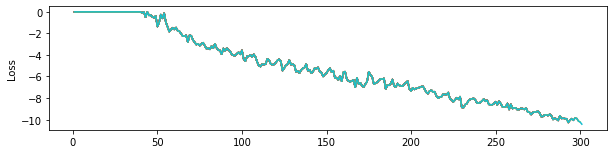

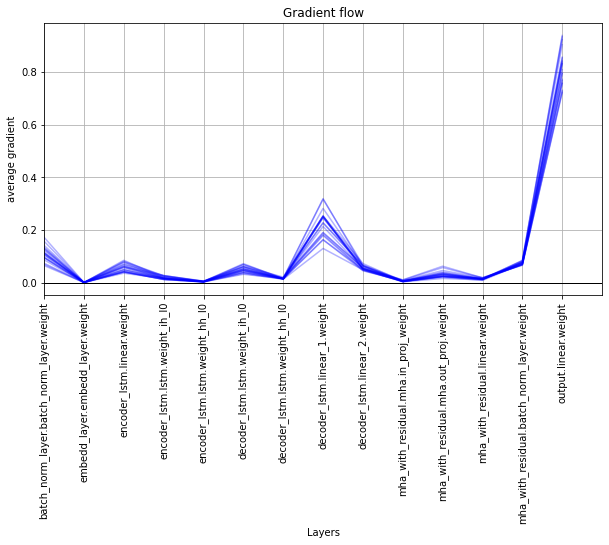

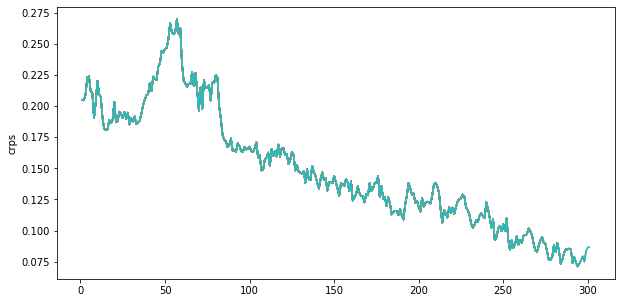

Training for Iteration: 0 Batch 301 starts
Training for Iteration: 0 Batch 302 starts
Training for Iteration: 0 Batch 303 starts
Training for Iteration: 0 Batch 304 starts
Training for Iteration: 0 Batch 305 starts
Training for Iteration: 0 Batch 306 starts
Training for Iteration: 0 Batch 307 starts
Training for Iteration: 0 Batch 308 starts
Training for Iteration: 0 Batch 309 starts
Training for Iteration: 0 Batch 310 starts
Training for Iteration: 0 Batch 311 starts
Training for Iteration: 0 Batch 312 starts
Training for Iteration: 0 Batch 313 starts
Training for Iteration: 0 Batch 314 starts
Training for Iteration: 0 Batch 315 starts
Training for Iteration: 0 Batch 316 starts
Training for Iteration: 0 Batch 317 starts
Training for Iteration: 0 Batch 318 starts
Training for Iteration: 0 Batch 319 starts
Training for Iteration: 0 Batch 320 starts


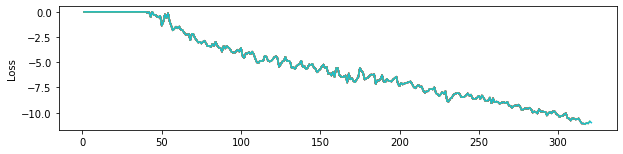

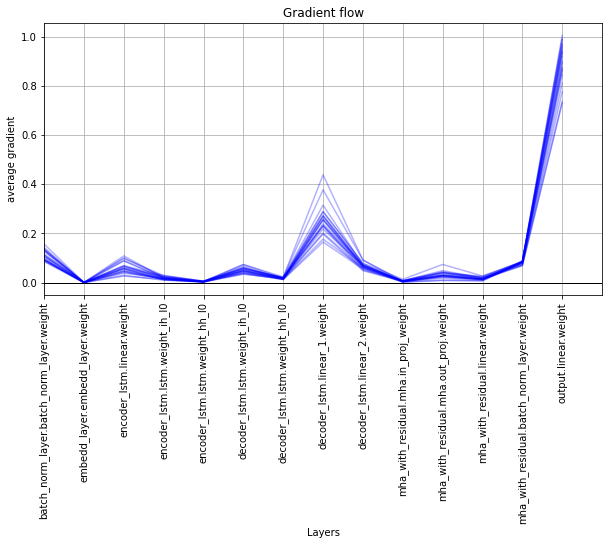

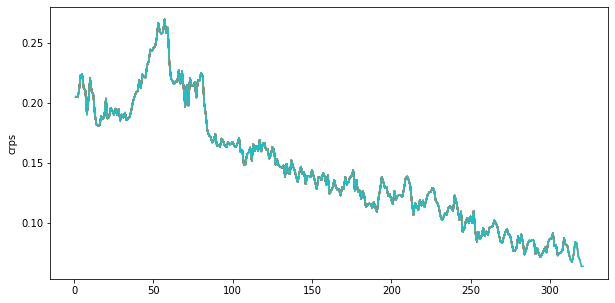

Training for Iteration: 0 Batch 321 starts
Training for Iteration: 0 Batch 322 starts
Training for Iteration: 0 Batch 323 starts
Training for Iteration: 0 Batch 324 starts
Training for Iteration: 0 Batch 325 starts
Training for Iteration: 0 Batch 326 starts
Training for Iteration: 0 Batch 327 starts
Training for Iteration: 0 Batch 328 starts
Training for Iteration: 0 Batch 329 starts
Training for Iteration: 0 Batch 330 starts
Training for Iteration: 0 Batch 331 starts
Training for Iteration: 0 Batch 332 starts
Training for Iteration: 0 Batch 333 starts
Training for Iteration: 0 Batch 334 starts
Training for Iteration: 0 Batch 335 starts
Training for Iteration: 0 Batch 336 starts
Training for Iteration: 0 Batch 337 starts
Training for Iteration: 0 Batch 338 starts
Training for Iteration: 0 Batch 339 starts
Training for Iteration: 0 Batch 340 starts


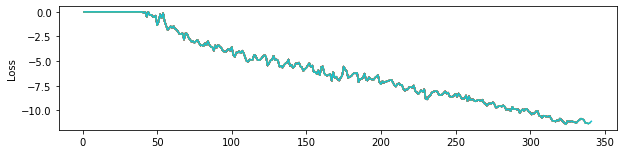

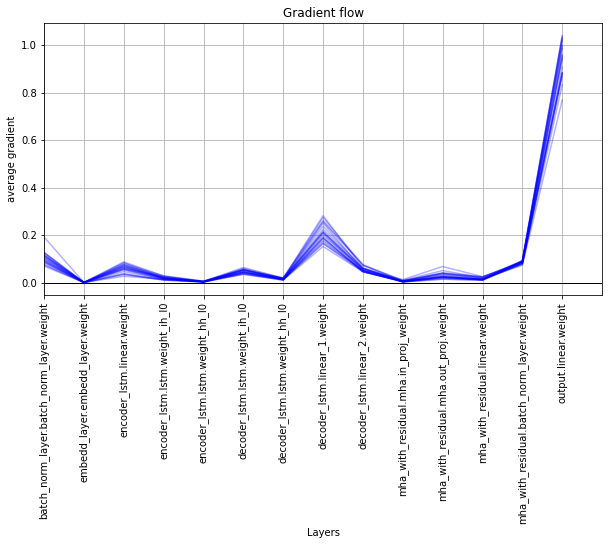

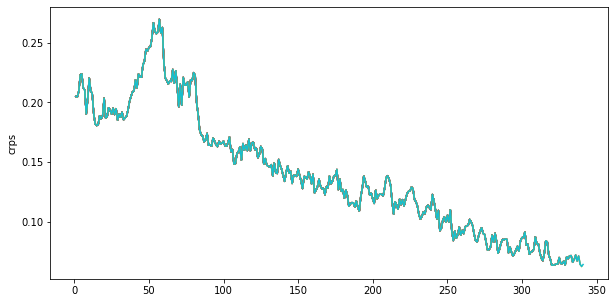

Training for Iteration: 0 Batch 341 starts
Training for Iteration: 0 Batch 342 starts
Training for Iteration: 0 Batch 343 starts
Training for Iteration: 0 Batch 344 starts
Training for Iteration: 0 Batch 345 starts
Training for Iteration: 0 Batch 346 starts
Training for Iteration: 0 Batch 347 starts
Training for Iteration: 0 Batch 348 starts
Training for Iteration: 0 Batch 349 starts
Training for Iteration: 0 Batch 350 starts
Training for Iteration: 0 Batch 351 starts
Training for Iteration: 0 Batch 352 starts
Training for Iteration: 0 Batch 353 starts
Training for Iteration: 0 Batch 354 starts
Training for Iteration: 0 Batch 355 starts
Training for Iteration: 0 Batch 356 starts
Training for Iteration: 0 Batch 357 starts
Training for Iteration: 0 Batch 358 starts
Training for Iteration: 0 Batch 359 starts
Training for Iteration: 0 Batch 360 starts


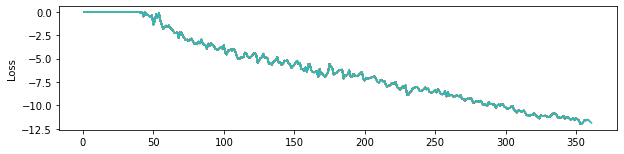

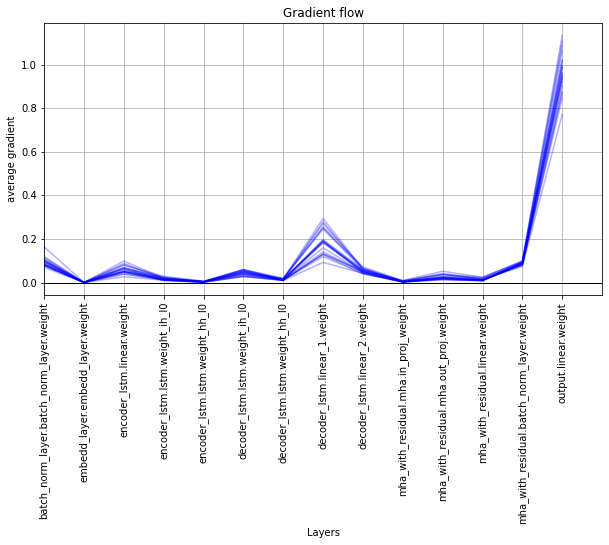

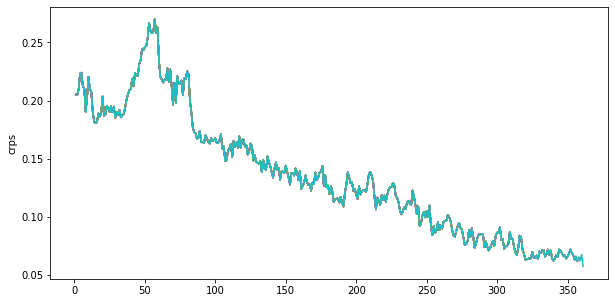

Training for Iteration: 0 Batch 361 starts
Training for Iteration: 0 Batch 362 starts
Training for Iteration: 0 Batch 363 starts
Training for Iteration: 0 Batch 364 starts
Training for Iteration: 0 Batch 365 starts
Training for Iteration: 0 Batch 366 starts
Training for Iteration: 0 Batch 367 starts
Training for Iteration: 0 Batch 368 starts
Training for Iteration: 0 Batch 369 starts
Training for Iteration: 0 Batch 370 starts
Training for Iteration: 0 Batch 371 starts
Training for Iteration: 0 Batch 372 starts
Training for Iteration: 0 Batch 373 starts
Training for Iteration: 0 Batch 374 starts
Training for Iteration: 0 Batch 375 starts
Training for Iteration: 0 Batch 376 starts
Training for Iteration: 0 Batch 377 starts
Training for Iteration: 0 Batch 378 starts
Training for Iteration: 0 Batch 379 starts
Training for Iteration: 0 Batch 380 starts


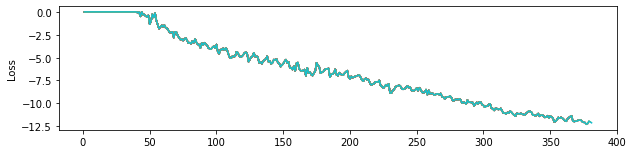

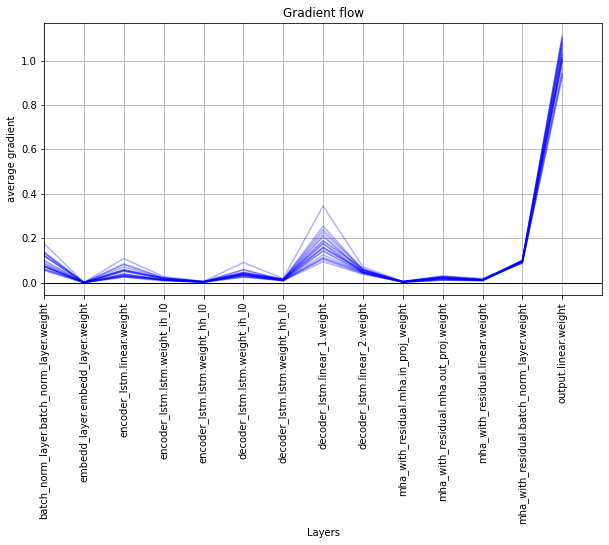

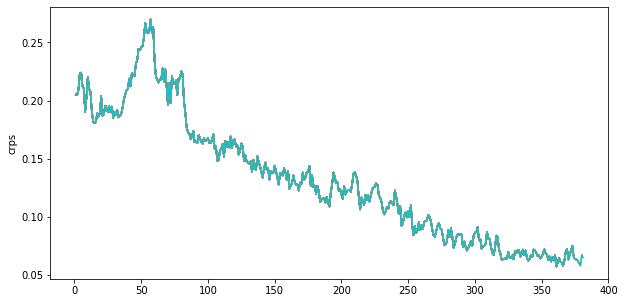

Training for Iteration: 0 Batch 381 starts
Training for Iteration: 0 Batch 382 starts
Training for Iteration: 0 Batch 383 starts
Training for Iteration: 0 Batch 384 starts
Training for Iteration: 0 Batch 385 starts
Training for Iteration: 0 Batch 386 starts
Training for Iteration: 0 Batch 387 starts
Training for Iteration: 0 Batch 388 starts
Training for Iteration: 0 Batch 389 starts
Training for Iteration: 0 Batch 390 starts
Training for Iteration: 0 Batch 391 starts
Training for Iteration: 0 Batch 392 starts
Training for Iteration: 0 Batch 393 starts
Training for Iteration: 0 Batch 394 starts
Training for Iteration: 0 Batch 395 starts
Training for Iteration: 0 Batch 396 starts
Training for Iteration: 0 Batch 397 starts
Training for Iteration: 0 Batch 398 starts
Training for Iteration: 0 Batch 399 starts
Training for Iteration: 0 Batch 400 starts


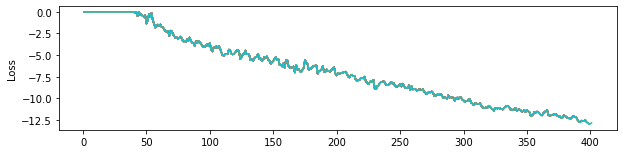

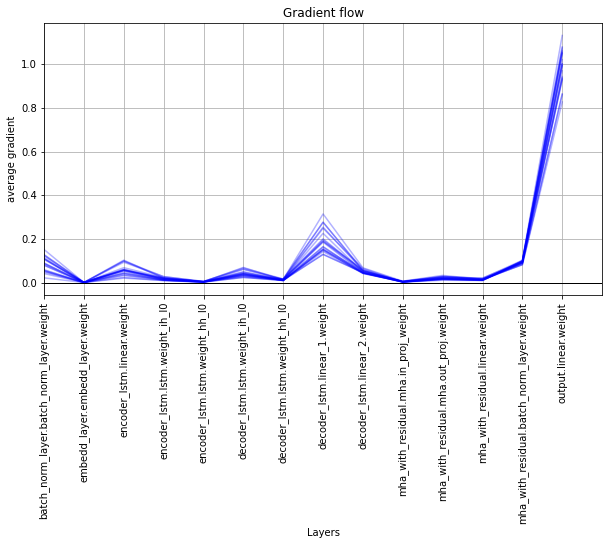

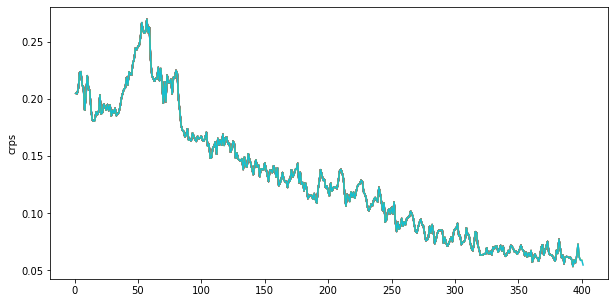

Training for Iteration: 0 Batch 401 starts
Training for Iteration: 0 Batch 402 starts
Training for Iteration: 0 Batch 403 starts
Training for Iteration: 0 Batch 404 starts
Training for Iteration: 0 Batch 405 starts
Training for Iteration: 0 Batch 406 starts
Training for Iteration: 0 Batch 407 starts
Training for Iteration: 0 Batch 408 starts
Training for Iteration: 0 Batch 409 starts
Training for Iteration: 0 Batch 410 starts
Training for Iteration: 0 Batch 411 starts
Training for Iteration: 0 Batch 412 starts
Training for Iteration: 0 Batch 413 starts
Training for Iteration: 0 Batch 414 starts
Training for Iteration: 0 Batch 415 starts
Training for Iteration: 0 Batch 416 starts
Training for Iteration: 0 Batch 417 starts
Training for Iteration: 0 Batch 418 starts
Training for Iteration: 0 Batch 419 starts
Training for Iteration: 0 Batch 420 starts


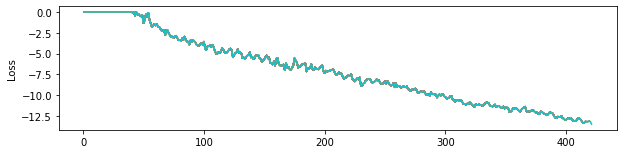

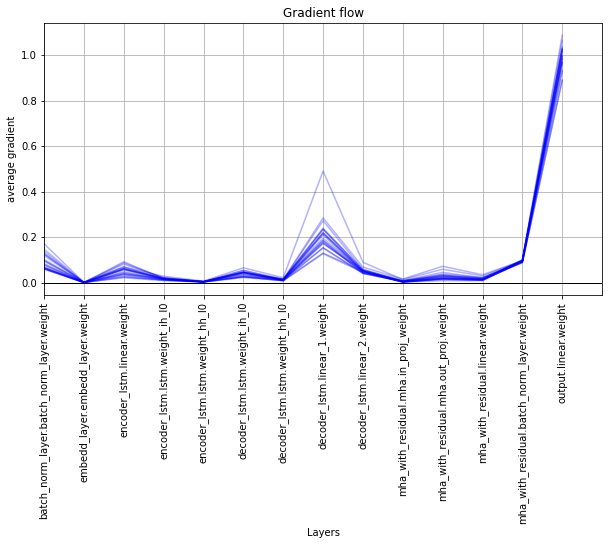

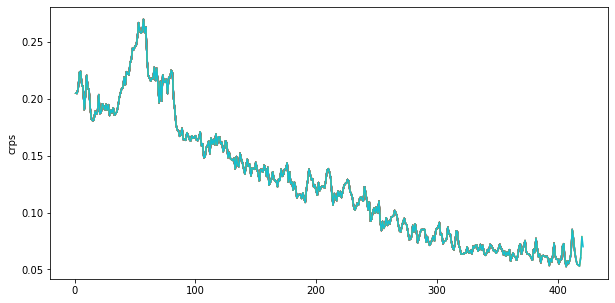

Training for Iteration: 0 Batch 421 starts
Training for Iteration: 0 Batch 422 starts
Training for Iteration: 0 Batch 423 starts
Training for Iteration: 0 Batch 424 starts
Training for Iteration: 0 Batch 425 starts
Training for Iteration: 0 Batch 426 starts
Training for Iteration: 0 Batch 427 starts
Training for Iteration: 0 Batch 428 starts
Training for Iteration: 0 Batch 429 starts
Training for Iteration: 0 Batch 430 starts
Training for Iteration: 0 Batch 431 starts
Training for Iteration: 0 Batch 432 starts
Training for Iteration: 0 Batch 433 starts
Training for Iteration: 0 Batch 434 starts
Training for Iteration: 0 Batch 435 starts
Training for Iteration: 0 Batch 436 starts
Training for Iteration: 0 Batch 437 starts
Training for Iteration: 0 Batch 438 starts
Training for Iteration: 0 Batch 439 starts
Training for Iteration: 0 Batch 440 starts


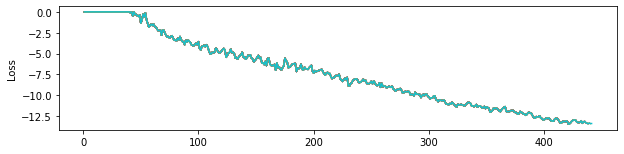

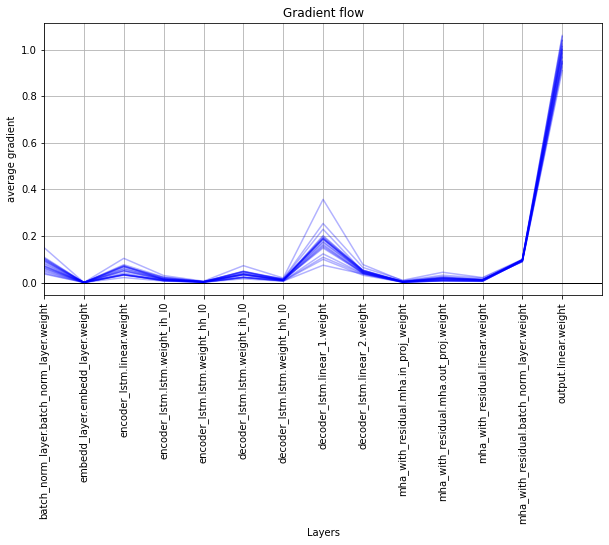

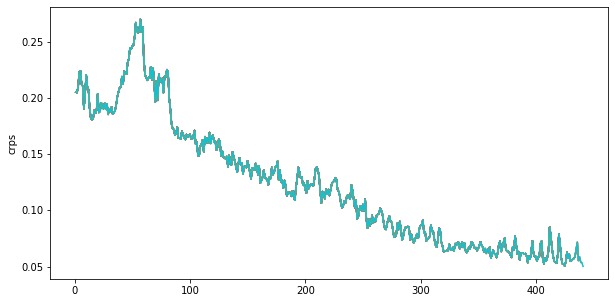

Training for Iteration: 0 Batch 441 starts
Training for Iteration: 0 Batch 442 starts
Training for Iteration: 0 Batch 443 starts
Training for Iteration: 0 Batch 444 starts
Training for Iteration: 0 Batch 445 starts
Training for Iteration: 0 Batch 446 starts
Training for Iteration: 0 Batch 447 starts
Training for Iteration: 0 Batch 448 starts
Training for Iteration: 0 Batch 449 starts
Training for Iteration: 0 Batch 450 starts
Training for Iteration: 0 Batch 451 starts
Training for Iteration: 0 Batch 452 starts
Training for Iteration: 0 Batch 453 starts
Training for Iteration: 0 Batch 454 starts
Training for Iteration: 0 Batch 455 starts
Training for Iteration: 0 Batch 456 starts
Training for Iteration: 0 Batch 457 starts
Training for Iteration: 0 Batch 458 starts
Training for Iteration: 0 Batch 459 starts
Training for Iteration: 0 Batch 460 starts


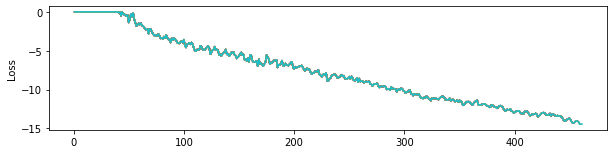

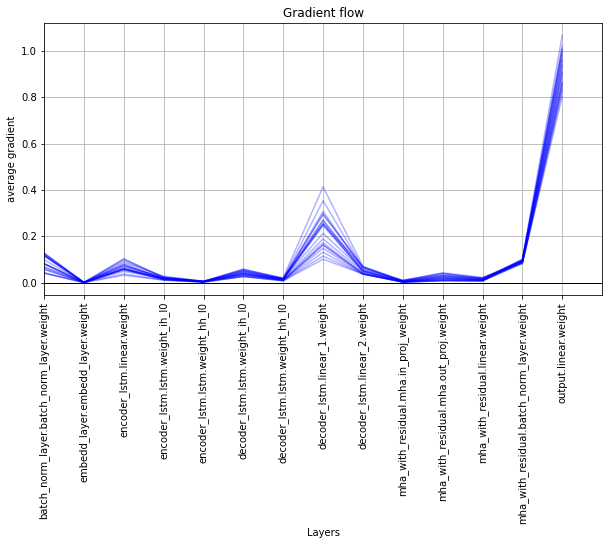

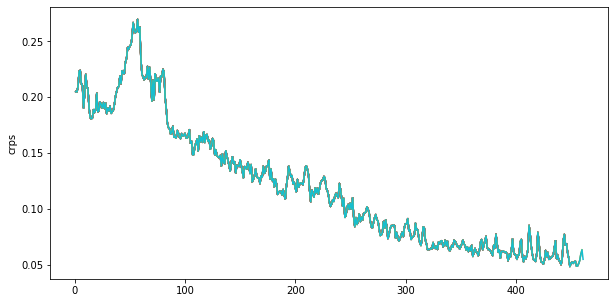

Training for Iteration: 0 Batch 461 starts
Training for Iteration: 0 Batch 462 starts
Training for Iteration: 0 Batch 463 starts
Training for Iteration: 0 Batch 464 starts
Training for Iteration: 0 Batch 465 starts
Training for Iteration: 0 Batch 466 starts
Training for Iteration: 0 Batch 467 starts
Training for Iteration: 0 Batch 468 starts
Training for Iteration: 0 Batch 469 starts
torch.Size([3, 3, 28, 3])
torch.Size([3, 3, 7, 1])
tensor(-14.5806, grad_fn=<NegBackward0>)
tensor([[6.0001, 1.4170, 2.9089],
        [6.6088, 1.3838, 3.0302],
        [4.9441, 0.8349, 1.4152],
        [1.1954, 0.6831, 0.6151],
        [2.6319, 0.8513, 1.9730],
        [4.7525, 1.0718, 2.5327],
        [5.5299, 1.4361, 2.7591]], grad_fn=<SqueezeBackward1>)
tensor([[0.6618, 0.0958, 0.2424],
        [0.6680, 0.0933, 0.2386],
        [0.6871, 0.0873, 0.2256],
        [0.6640, 0.1008, 0.2352],
        [0.6686, 0.0982, 0.2331],
        [0.6656, 0.0957, 0.2387],
        [0.6591, 0.1008, 0.2401]])
tensor(-14.4416

 10%|█         | 1/10 [03:44<33:41, 224.59s/it, loss=-7.818]

tensor(-14.4071, grad_fn=<NegBackward0>)
tensor([[5.9025, 1.3431, 2.7831],
        [6.6869, 1.4333, 2.9520],
        [4.8760, 0.8458, 1.4114],
        [1.1505, 0.6444, 0.5627],
        [2.6029, 0.7769, 1.8931],
        [4.7293, 1.0251, 2.4899],
        [5.4967, 1.4038, 2.7370]], grad_fn=<SqueezeBackward1>)
tensor([[0.6871, 0.0873, 0.2256],
        [0.6640, 0.1008, 0.2352],
        [0.6686, 0.0982, 0.2331],
        [0.6656, 0.0957, 0.2387],
        [0.6591, 0.1008, 0.2401],
        [0.6521, 0.0978, 0.2502],
        [0.6558, 0.0940, 0.2502]])
tensor(-43.4293, grad_fn=<AddBackward0>)
Trainign for Iteration: 1 starts
Training for Iteration: 1 Batch 0 starts
Training for Iteration: 1 Batch 1 starts
Training for Iteration: 1 Batch 2 starts
Training for Iteration: 1 Batch 3 starts
Training for Iteration: 1 Batch 4 starts
Training for Iteration: 1 Batch 5 starts
Training for Iteration: 1 Batch 6 starts
Training for Iteration: 1 Batch 7 starts
Training for Iteration: 1 Batch 8 starts
Training f

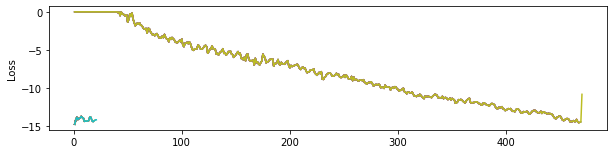

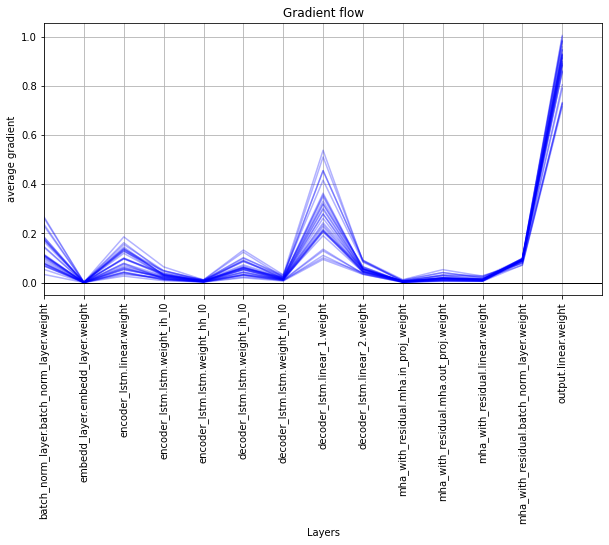

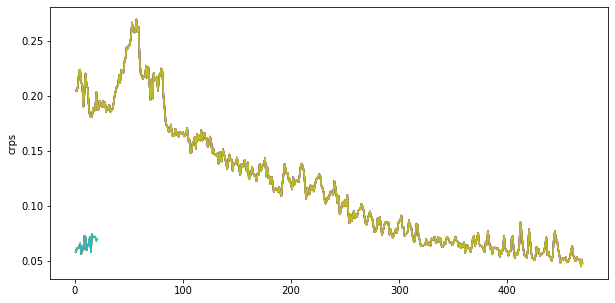

Training for Iteration: 1 Batch 21 starts
Training for Iteration: 1 Batch 22 starts
Training for Iteration: 1 Batch 23 starts
Training for Iteration: 1 Batch 24 starts
Training for Iteration: 1 Batch 25 starts
Training for Iteration: 1 Batch 26 starts
Training for Iteration: 1 Batch 27 starts
Training for Iteration: 1 Batch 28 starts
Training for Iteration: 1 Batch 29 starts
Training for Iteration: 1 Batch 30 starts
Training for Iteration: 1 Batch 31 starts
Training for Iteration: 1 Batch 32 starts
Training for Iteration: 1 Batch 33 starts
Training for Iteration: 1 Batch 34 starts
Training for Iteration: 1 Batch 35 starts
Training for Iteration: 1 Batch 36 starts
Training for Iteration: 1 Batch 37 starts
Training for Iteration: 1 Batch 38 starts
Training for Iteration: 1 Batch 39 starts
Training for Iteration: 1 Batch 40 starts


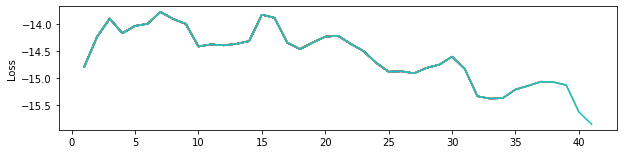

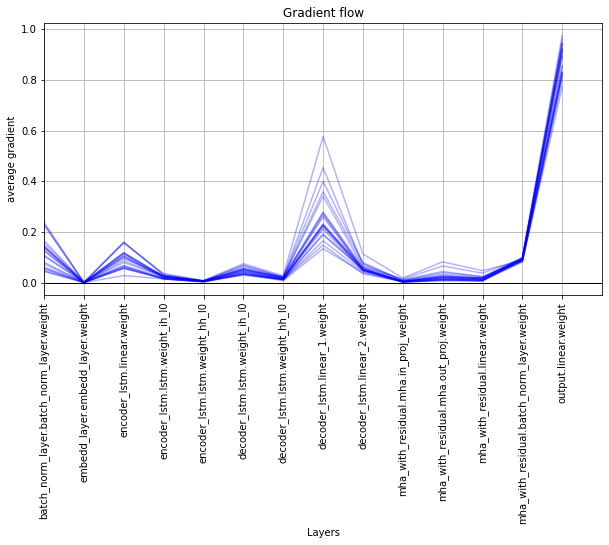

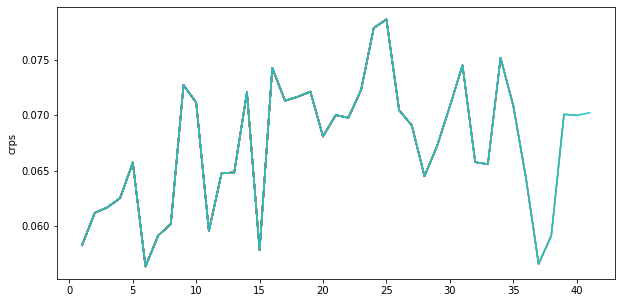

Training for Iteration: 1 Batch 41 starts
Training for Iteration: 1 Batch 42 starts
Training for Iteration: 1 Batch 43 starts
Training for Iteration: 1 Batch 44 starts
Training for Iteration: 1 Batch 45 starts
Training for Iteration: 1 Batch 46 starts
Training for Iteration: 1 Batch 47 starts
Training for Iteration: 1 Batch 48 starts
Training for Iteration: 1 Batch 49 starts
Training for Iteration: 1 Batch 50 starts
Training for Iteration: 1 Batch 51 starts
Training for Iteration: 1 Batch 52 starts
Training for Iteration: 1 Batch 53 starts
Training for Iteration: 1 Batch 54 starts
Training for Iteration: 1 Batch 55 starts
Training for Iteration: 1 Batch 56 starts
Training for Iteration: 1 Batch 57 starts
Training for Iteration: 1 Batch 58 starts
Training for Iteration: 1 Batch 59 starts
Training for Iteration: 1 Batch 60 starts


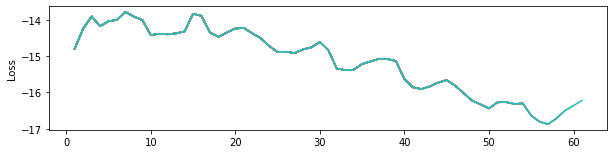

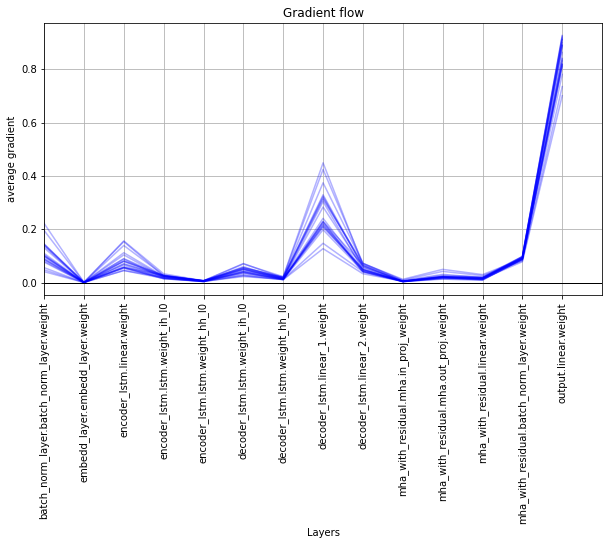

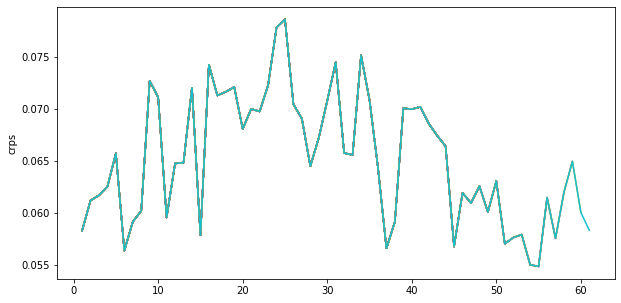

Training for Iteration: 1 Batch 61 starts
Training for Iteration: 1 Batch 62 starts
Training for Iteration: 1 Batch 63 starts
Training for Iteration: 1 Batch 64 starts
Training for Iteration: 1 Batch 65 starts
Training for Iteration: 1 Batch 66 starts
Training for Iteration: 1 Batch 67 starts
Training for Iteration: 1 Batch 68 starts
Training for Iteration: 1 Batch 69 starts
Training for Iteration: 1 Batch 70 starts
Training for Iteration: 1 Batch 71 starts
Training for Iteration: 1 Batch 72 starts
Training for Iteration: 1 Batch 73 starts
Training for Iteration: 1 Batch 74 starts
Training for Iteration: 1 Batch 75 starts
Training for Iteration: 1 Batch 76 starts
Training for Iteration: 1 Batch 77 starts
Training for Iteration: 1 Batch 78 starts
Training for Iteration: 1 Batch 79 starts
Training for Iteration: 1 Batch 80 starts


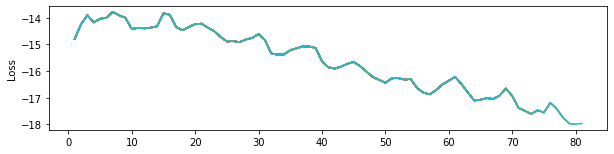

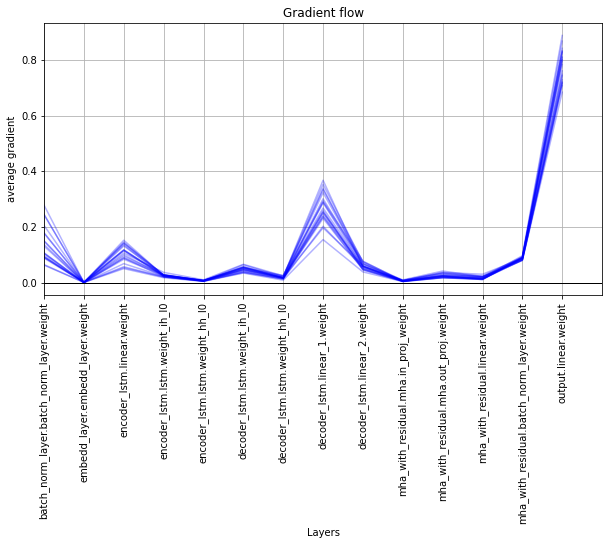

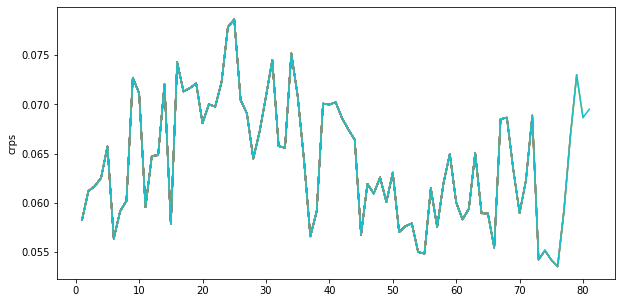

Training for Iteration: 1 Batch 81 starts
Training for Iteration: 1 Batch 82 starts
Training for Iteration: 1 Batch 83 starts
Training for Iteration: 1 Batch 84 starts
Training for Iteration: 1 Batch 85 starts
Training for Iteration: 1 Batch 86 starts
Training for Iteration: 1 Batch 87 starts
Training for Iteration: 1 Batch 88 starts
Training for Iteration: 1 Batch 89 starts
Training for Iteration: 1 Batch 90 starts
Training for Iteration: 1 Batch 91 starts
Training for Iteration: 1 Batch 92 starts
Training for Iteration: 1 Batch 93 starts
Training for Iteration: 1 Batch 94 starts
Training for Iteration: 1 Batch 95 starts
Training for Iteration: 1 Batch 96 starts
Training for Iteration: 1 Batch 97 starts
Training for Iteration: 1 Batch 98 starts
Training for Iteration: 1 Batch 99 starts
Training for Iteration: 1 Batch 100 starts


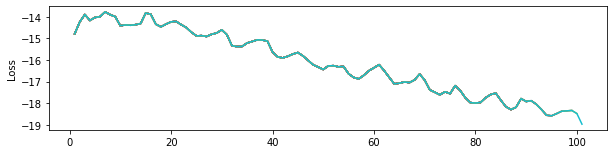

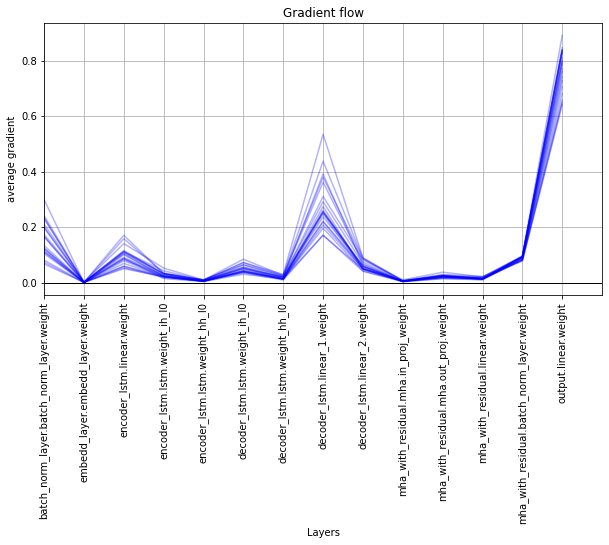

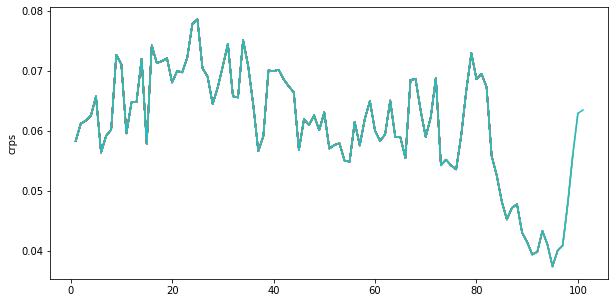

Training for Iteration: 1 Batch 101 starts
Training for Iteration: 1 Batch 102 starts
Training for Iteration: 1 Batch 103 starts
Training for Iteration: 1 Batch 104 starts
Training for Iteration: 1 Batch 105 starts
Training for Iteration: 1 Batch 106 starts
Training for Iteration: 1 Batch 107 starts
Training for Iteration: 1 Batch 108 starts
Training for Iteration: 1 Batch 109 starts
Training for Iteration: 1 Batch 110 starts
Training for Iteration: 1 Batch 111 starts
Training for Iteration: 1 Batch 112 starts


 10%|█         | 1/10 [04:39<41:51, 279.07s/it, loss=-7.818]

Training for Iteration: 1 Batch 113 starts


KeyboardInterrupt: 

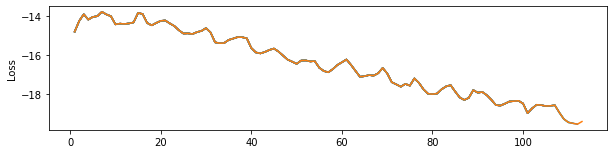

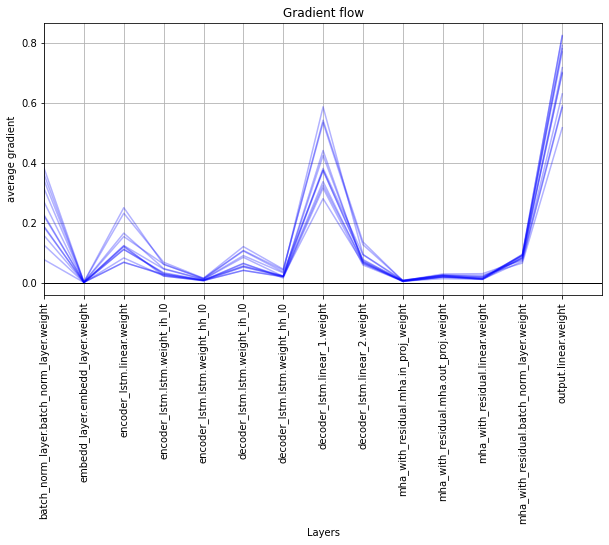

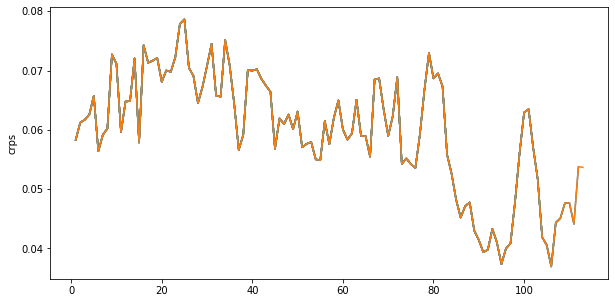

In [113]:
###---------- trainign parameters from the paper ------------ ######
n_epochs = 10
target_len = Forward
batch_size = 4
l_r = 0.00079

## Training without gradient clipping 
model, iter_losses = proption_model.train_model(
    model, 
    input_tensor, 
    target_tensor, 
    n_epochs, 
    target_len, 
    batch_size, 
    l_r,
    clip = False,
    tracing = True, 
    val_input_tensor=val_input_tensor,
    val_target_tensor=val_targer_tensor,
    epsilon=1e-07,
    threshold=1e-08,
    complex_modification=False,
)

In [151]:
# PATH = 'model_artifacts/10Iteration__LR0.000079__Clipp__ReluMHA__Epsilon1e-07__Threshold_1e-08_.pt'
# torch.save(
#     {   
#         'lr' : l_r,
#         'epoch': 10,
#         'batch': 4,
#         'model_state_dict': model.state_dict(),
#         'loss': iter_losses,
#     }, 
#     PATH
# )

In [130]:
# compute the training crps 
number_of_samples = 10
crpss = []
for observation_index in range(input_tensor.shape[0]): 

    pred = model(input_tensor[0])[0]

    samples = Dirichlet(pred).sample((number_of_samples,))

    truth = target_tensor[observation_index].permute(2,1,0).squeeze(dim=0)

    crpss.append(eval_crps(pred=samples, truth=truth)) 

In [132]:
crps_plot = go.Figure()

crps_plot.add_trace(
    go.Scatter(
        name= 'Training CRPS',
        mode= "lines", 
        x=list(range(len(crpss))), 
        y=crpss,
    )
)

In [127]:
pred = model(input_tensor[0])[0]

samples = Dirichlet(pred).sample((3,))
samples.shape 

torch.Size([3, 7, 3])

In [126]:
target_tensor[0].permute(2,1,0).squeeze(dim=0)

tensor([[0.6655, 0.1367, 0.1978],
        [0.7197, 0.0738, 0.2065],
        [0.7093, 0.0834, 0.2073],
        [0.7244, 0.0801, 0.1955],
        [0.7356, 0.0760, 0.1884],
        [0.7345, 0.0790, 0.1865],
        [0.7429, 0.0701, 0.1870]])

In [128]:
eval_crps(pred=samples, truth=target_tensor[0].permute(2,1,0).squeeze(dim=0))

0.039326149970293045

In [110]:
target_tensor[0].permute(1,2,0,)

tensor([[[0.6655, 0.1367, 0.1978]],

        [[0.7197, 0.0738, 0.2065]],

        [[0.7093, 0.0834, 0.2073]],

        [[0.7244, 0.0801, 0.1955]],

        [[0.7356, 0.0760, 0.1884]],

        [[0.7345, 0.0790, 0.1865]],

        [[0.7429, 0.0701, 0.1870]]])

- # TODOS: check the method the learnign rate decay over epoch 
- # TODOS: check the output and target while the loss suddenly increases 


In [113]:
mean = np.empty((target_tensor.shape[0], input.shape[0]))
min = np.empty((target_tensor.shape[0], input.shape[0]))
max = np.empty((target_tensor.shape[0], input.shape[0])) 
dates = []

# per observation loop for interval constrcutor
for observation_index in range(target_tensor.shape[0]):

    model.eval()
    output, decoder_ouputs, value  = model.forward(input_tensor[observation_index]) 
    output = torch.squeeze(output, dim=-1) 

    #print(f"There are {output.shape[0]} timestamp in the output.")
    if observation_index == 0 : 
        for i in range(output.shape[0]):

            date = ac_df_t.loc[i+28]['index']
            dates.append(date)
            
            ouput_dist = Dirichlet(concentration=output[i])
            samples = ouput_dist.sample((1,))

            target_expected = torch.mean(samples,dim=0)
            target_min = torch.min(samples, dim=0)
            target_max = torch.max(samples, dim=0)

            mean[i] = (target_expected)
            min[i] = (target_min.values)
            max[i] = (target_max.values)
    elif observation_index <= 6:
        continue
    else: 
        date = ac_df_t.loc[observation_index+28+output.shape[-1]-1]['index']
        dates.append(date)
        
        ouput_dist = Dirichlet(concentration=output[-1])
        samples = ouput_dist.sample((200,))

        target_expected = torch.mean(samples,dim=0)
        target_min = torch.min(samples, dim=0)
        target_max = torch.max(samples, dim=0)

        mean[observation_index] = (target_expected)
        min[observation_index] = (target_min.values)
        max[observation_index] = (target_max.values)

In [114]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
        )
    )

for i in range(mean.shape[-1]):
    fig.add_traces(
        go.Scatter(
            name= f'mean_{i}_10EPOCH',
            mode='lines',
            x=dates,
            y=mean[:,i],
        ),
    )

# for i in range(min.shape[-1]):
#     fig.add_traces(
#         go.Scatter(
#             name= f'min_max_{i}_10EPOCH',
#             mode='lines',
#             x=dates+dates[::-1],
#             y=min[:,i]+max[:,i][::-1],
#             fill='toself',
#             fillcolor='rgba(0,100,80,0.2)',
#             line=dict(color='rgba(255,255,255,0)'),
#             hoverinfo="skip",
#         ),
#     )
fig.show()

# Comparative Expriment Sessions 

In [286]:
# define the model object without batchnotm
model_layer_norm = proption_model.ProportionModel(
    Forward,
    num_hts_embedd,
    hts_embedd_dim,  # ts embedding hyper pars
    lstm_input_dim,
    lstm_hidden_dim,
    lstm_num_layer,
    lstm_output_dim,  # lstm hyper pars
    mha_embedd_dim,
    num_head,
    num_attention_layer,  # mha hyper pars
    mha_output_dim,
    residual_output_dim,  # skip connection hyper pars
    model_ouput_dim,  # output later hyper pars
    mha_activation = torch.nn.LeakyReLU()
)

###---------- trainign parameters from the paper ------------ ######
n_epochs = 10
target_len = Forward
batch_size = 4
l_r = 0.00079

In [290]:
mean = np.empty((target_tensor.shape[0], input.shape[0]))
min = np.empty((target_tensor.shape[0], input.shape[0]))
max = np.empty((target_tensor.shape[0], input.shape[0])) 
dates = []

# per observation loop for interval constrcutor
for observation_index in range(target_tensor.shape[0]):

    model.eval()
    output, decoder_ouputs, value  = model_layer_norm.forward(input_tensor[observation_index]) 
    output = torch.squeeze(output, dim=-1) 

    #print(f"There are {output.shape[0]} timestamp in the output.")
    if observation_index == 0 : 
        for i in range(output.shape[0]):

            date = ac_df_t.loc[i+28]['index']
            dates.append(date)
            
            ouput_dist = Dirichlet(concentration=output[i])
            samples = ouput_dist.sample((200,))

            target_expected = torch.mean(samples,dim=0)
            target_min = torch.min(samples, dim=0)
            target_max = torch.max(samples, dim=0)

            mean[i] = (target_expected)
            min[i] = (target_min.values)
            max[i] = (target_max.values)
    elif observation_index <= 6:
        continue
    else: 
        date = ac_df_t.loc[observation_index+28+output.shape[-1]-1]['index']
        dates.append(date)
        
        ouput_dist = Dirichlet(concentration=output[-1])
        samples = ouput_dist.sample((200,))

        target_expected = torch.mean(samples,dim=0)
        target_min = torch.min(samples, dim=0)
        target_max = torch.max(samples, dim=0)

        mean[observation_index] = (target_expected)
        min[observation_index] = (target_min.values)
        max[observation_index] = (target_max.values)

In [291]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
        )
    )

for i in range(mean.shape[-1]):
    fig.add_traces(
        go.Scatter(
            name= f'mean_{i}_10EPOCH',
            mode='lines',
            x=dates,
            y=mean[:,i],
        ),
    )

for i in range(min.shape[-1]):
    fig.add_traces(
        go.Scatter(
            name= f'min_max_{i}_10EPOCH',
            mode='lines',
            x=dates+dates[::-1],
            y=min[:,i]+max[:,i][::-1],
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
        ),
    )
fig.show()

In [288]:
PATH = 'model_artifacts/10Iteration__LR0.00079__NonClipp__LeakyReluMHA__Epsilon1e-07__Threshold_13-08__ComplexLossisTRUE_NOBatchNorm.pt'
torch.save(
    {   'lr' : l_r,
        'epoch': 10,
        'model_state_dict': model_no_batch_norm.state_dict(),
        'loss': iter_losses,
    }, 
    PATH
)

In [289]:
PATH = 'model_artifacts/10Iteration__LR0.00079__NonClipp__LeakyReluMHA__Epsilon1e-07__Threshold_13-08__ComplexLossisTRUE_layerNorm.pt'
torch.save(
    {   'lr' : l_r,
        'epoch': 10,
        'model_state_dict': model_layer_norm.state_dict(),
        'loss': iter_losses,
    }, 
    PATH
)

In [109]:
input_tensor.shape 

torch.Size([1879, 3, 28, 3])

In [115]:
print(input_tensor[0].shape)

torch.Size([3, 28, 3])


- Vlidate whether the learning is happening: 

In [296]:
trained_model = torch.load(
    'model_artifacts/10Iteration__LR0.00079__NonClipp__LeakyReluMHA__Epsilon1e-07__Threshold_13-08__ComplexLossisTRUE.pt'
)

In [297]:
model.load_state_dict(trained_model['model_state_dict'])

<All keys matched successfully>

In [300]:
mean = np.empty((target_tensor.shape[0], input.shape[0]))
min = np.empty((target_tensor.shape[0], input.shape[0]))
max = np.empty((target_tensor.shape[0], input.shape[0])) 
dates = []

# per observation loop for interval constrcutor
for observation_index in range(target_tensor.shape[0]):

    model.eval()
    output, decoder_ouputs, value  = model.forward(input_tensor[observation_index]) 
    output = torch.squeeze(output, dim=-1) 

    #print(f"There are {output.shape[0]} timestamp in the output.")
    if observation_index == 0 : 
        for i in range(output.shape[0]):

            date = ac_df_t.loc[i+28]['index']
            dates.append(date)
            
            ouput_dist = Dirichlet(concentration=output[i])
            samples = ouput_dist.sample((200,))

            target_expected = torch.mean(samples,dim=0)
            target_min = torch.min(samples, dim=0)
            target_max = torch.max(samples, dim=0)

            mean[i] = (target_expected)
            min[i] = (target_min.values)
            max[i] = (target_max.values)
    elif observation_index <= 6:
        continue
    else: 
        date = ac_df_t.loc[observation_index+28+output.shape[-1]-1]['index']
        dates.append(date)
        
        ouput_dist = Dirichlet(concentration=output[-1])
        samples = ouput_dist.sample((200,))

        target_expected = torch.mean(samples,dim=0)
        target_min = torch.min(samples, dim=0)
        target_max = torch.max(samples, dim=0)

        mean[observation_index] = (target_expected)
        min[observation_index] = (target_min.values)
        max[observation_index] = (target_max.values)

In [299]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
        )
    )
fig.show()

0            NaN
1            NaN
2            NaN
3            NaN
4       0.710306
          ...   
1908    0.661821
1909    0.668029
1910    0.687117
1911     0.66404
1912    0.668647
Name: FOODS, Length: 1913, dtype: object

In [308]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label].rolling(4).mean(),
        #marker_symbol="star"
        )
    )

for i in range(mean.shape[-1]):
    fig.add_traces(
        go.Scatter(
            name= f'mean_{i}_10EPOCH',
            mode='lines',
            x=dates,
            y=mean[:,i],
        ),
    )

# for i in range(min.shape[-1]):
#     fig.add_traces(
#         go.Scatter(
#             name= f'min_max_{i}_10EPOCH',
#             mode='lines',
#             x=dates+dates[::-1],
#             y=min[:,i]+max[:,i][::-1],
#             fill='toself',
#             fillcolor='rgba(0,100,80,0.2)',
#             line=dict(color='rgba(255,255,255,0)'),
#             hoverinfo="skip",
#         ),
#     )
fig.show()

In [259]:
ac_df_t.loc[27]

cat_id
index        2011-02-25
FOODS          0.687114
HOBBIES        0.118736
HOUSEHOLD       0.19415
Name: 27, dtype: object

In [258]:
mean[0,:,0,:]

array([0.61965173, 0.12935528, 0.25099301])

In [ ]:
# input_array = np.empty((
#     number_observations,
#     input.shape[0],
#     History,
#     input.shape[-1])
# )

# target_array = np.empty((
#     number_observations,
#     input.shape[0],
#     Forward,
#     1)
# )

In [264]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
        )
    )

fig.show()

In [265]:
fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
    )
)


- #TODO: learning across iterations is not improving obviously 

- #Across family learning: Order to be carried out (which family to start with?)

## Time related covariates: 

- Wehther it is weekend/not, we observed sales are high overweekend across three categories 

In [4]:
date = [d_to_date[d] for d in sales_train_validation.columns[6:]]

In [5]:
print(f'The statrting date is {date[0]}')
print(f'The statrting date is {date[-1]}')

The statrting date is 2011-01-29
The statrting date is 2016-04-24


In [6]:
d = datetime.strptime(date[2], '%Y-%m-%d')
if d.weekday() > 4:
    print ('Given date is weekend.')
else:
    print ('Given data is weekday.')

Given data is weekday.


In [7]:
d.weekday()

0

In [8]:
weekend_binary = [1 if (datetime.strptime(d, '%Y-%m-%d')).weekday() > 4 else 0 for d in date]
print(len(weekend_binary))

1913


## Proportions

In [9]:
stv = sales_train_validation[sales_train_validation.columns[6:]]
stv = stv.T
print(stv.shape)

(1913, 30490)


In [10]:
len(stv.sum(axis=1).values)

1913

## Time series embeddings 

In [13]:
hie_index = torch.arange(stv.shape[1])

hie_index_2d = hie_index.expand(stv.shape[0], stv.shape[1])

hie_index_3d = hie_index_2d.reshape(
    hie_index_2d.shape[0], hie_index_2d.shape[-1], 1
)

print(hie_index_3d.shape)


torch.Size([1913, 30490, 1])


In [14]:
stv_proportions = np.divide(stv.values, stv.sum(axis=1).values.reshape(-1,1))
print(stv_proportions.sum(axis=1).sum())

stv_proportions_3d = stv_proportions.reshape(stv_proportions.shape[0], stv_proportions.shape[1], 1)
print(stv_proportions_3d.shape)

proportions_tensor = torch.tensor(stv_proportions_3d)
print(proportions_tensor.shape)

1913.0
(1913, 30490, 1)
torch.Size([1913, 30490, 1])


In [15]:

weekend_binary_tensor = torch.tensor(weekend_binary).unsqueeze_(-1).unsqueeze_(-1)
weekend_binary_tensor = weekend_binary_tensor.expand(stv_proportions.shape[0], stv_proportions.shape[1], weekend_binary_tensor.shape[-1])
print(weekend_binary_tensor.shape)
print(weekend_binary_tensor[1,0])
print(weekend_binary_tensor[2,0])


torch.Size([1913, 30490, 1])
tensor([1])
tensor([0])


In [16]:
parent_sales_tensor = torch.tensor(parent_sales).unsqueeze_(-1).unsqueeze_(-1)
parent_sales_tensor = parent_sales_tensor.expand(stv_proportions.shape[0], stv_proportions.shape[1], parent_sales_tensor.shape[-1])
print(parent_sales_tensor.shape)

torch.Size([1913, 30490, 1])


In [17]:
data_3d = torch.cat((proportions_tensor, parent_sales_tensor,weekend_binary_tensor, hie_index_3d), -1)
data_3d = data_3d.double()
print(data_3d.shape)

torch.Size([1913, 30490, 4])


In [18]:
# dimension about the dataset
no_child = proportions_tensor.shape[1]
History = 28
Forward = 28

number_observations = data_3d.shape[0] - (History + Forward) + 1

data_3d_time_batched = torch.empty(
    number_observations, History + Forward, data_3d.shape[1], data_3d.shape[2]
)

for i in range(number_observations):

    data_3d_time_batched[i, :, :, :] = data_3d[i : i + History + Forward, :, :]

print(data_3d_time_batched.shape)
print(data_3d_time_batched[-1,:,:,:].shape)


#if torch.equal(data_3d_time_batched[-1, -1, :, :].double(), data_3d[-1, :, :].double()):

print("data correctly processed to generate time-bacted tensor")

input_tensor = torch.empty(
    number_observations,
    History,
    data_3d_time_batched.shape[-2],
    data_3d_time_batched.shape[-1],
)

## We first use the recursive predicitng mechanism in LSTM, in the future we release more blocks that adapt to teacher-forcing/mixed training
target_tensor = torch.empty(
    number_observations,
    Forward,
    data_3d_time_batched.shape[-2],
    1
    # data_3d_time_batched.shape[-1]
)

print(input_tensor.shape)
print(target_tensor.shape)

print("Entering the training pipeline")

for i in range(data_3d_time_batched.shape[0]):

    input_tensor[i] = data_3d_time_batched[i, :History, :, :]
    target_2d = data_3d_time_batched[i, History:, :, 0]
    target_tensor[i] = target_2d.reshape(
        target_2d.shape[0], target_2d.shape[1], 1
    )

    # print(input_tensor.shape)
    # print(target_tensor.shape)

print(input_tensor.shape)
print(target_tensor.shape)
    # print(target_tensor[-1,0,:,:].sum())

torch.Size([1858, 56, 30490, 4])
torch.Size([56, 30490, 4])
data correctly processed to generate time-bacted tensor
torch.Size([1858, 28, 30490, 4])
torch.Size([1858, 28, 30490, 1])
Entering the training pipeline
torch.Size([1858, 28, 30490, 4])
torch.Size([1858, 28, 30490, 1])
